# Stage 2 - Data Pre-processing & Features Engineering
---

Kelompok 2:

*   Oei, Gabrielle Maureen B.S
*   Ummi Sarah
*   Arini Arumsari
*   Althaaf Athaayaa Daffa Qushayyizidane
*   Ruslan Hadi
*   Muhammad Ikhsan Hendriyana
*   Taufik Ismail
*   Jackson
*   Tsany Sutia

In [1]:
# Melakukan import library
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import boxcox
from imblearn import under_sampling
# import gdown
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, reset_parameter

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.24.4
pandas version :  2.0.3
seaborn version :  0.12.2


In [2]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [3]:
# Melakukan import csv
df = pd.read_csv("train.csv")
df.sample(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
260434,260435,Male,24,1,43.0,1,< 1 Year,No,46144.0,152.0,220,0
139799,139800,Male,24,1,8.0,0,< 1 Year,Yes,44580.0,152.0,60,0
220728,220729,Female,24,1,11.0,1,< 1 Year,No,2630.0,152.0,82,0
71097,71098,Female,55,1,8.0,0,1-2 Year,Yes,43105.0,124.0,264,0
154140,154141,Female,30,1,33.0,1,< 1 Year,No,37579.0,152.0,47,0


In [4]:
# Pengelompokan kolom berdasarkan jenisnya
nums = ['int64', 'int32', 'int16', 'float64', 'float32', 'float16']
nums = df.select_dtypes(include=nums)
nums.drop(columns=['id'],inplace=True)
nums = nums.columns
cats = ['Gender','Vehicle_Age','Vehicle_Damage']

Target dari modelling classification ini adalah kolom **`Response`**.

# Data Cleansing (50 poin)

## Missing Value

In [5]:
# Melihat jumlah baris dan kolom
test = df.shape[0]

# Mengecek missing value ditiap fitur
missing_values_count = df.isnull().sum()
missing_values_count

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [6]:
# Melakukan pengecekan terhadap karakter tertentu yang mungkin termasuk NaN/NULL
chara = ["-"," ","","."]

v_break = False

for i, row in df.iterrows():
    for column in df.columns:
        for z in chara:
            if row[column] == z:
                print(f"Terdapat {z} di baris {i}, kolom {column}")
                v_break = True
                break
        if v_break:
            break

if not v_break:
    print(f"Tidak ditemukan")

Tidak ditemukan


Setelah dilakukan pengecekan terhadap NULL/NaN values, tidak terdapat NULL/NaN pada dataset.

## Duplicated data


In [7]:
df.duplicated().sum()

0

In [8]:
df.duplicated(subset=['id'],keep=False).sum()

0

Setelah dilakukan pengecekan terhadap duplicated values, tidak terdapat data duplikasi pada dataset.

## Outliers

Dari grafik yang kita dapat ketika EDA yang telah dilakukan di Stage 1, kita tahu `Annual Premium` memiliki outliers yang cukup extreme sehingga ditangani dengan penghapusan IQR ataupun capping.

In [9]:
# membuat function untuk mencari IQR
d = df.shape[0]
a = ['Annual_Premium']
def find_limit(df, variables) :
    q1 = df[variables].quantile(0.25)
    q3 = df[variables].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - (1.5 * iqr)
    upper_limit = q3 + (1.5 * iqr)
    return lower_limit, upper_limit

In [10]:
# Membuang value outliers
df_clean = df.copy()

for i in a :
    lower, upper = find_limit(df_clean, i)
    df_clean = df_clean[~((df_clean[i] < lower) | (df_clean[i] > upper))]

df_clean = df_clean.reset_index(drop = True)

print(f'Jumlah baris sebelum memfilter outlier: {d}')
print(f'Jumlah baris setelah memfilter outlier: {len(df_clean)}')
print(f'Sebanyak {d-len(df_clean)} rows dihapuskan atau {round(((d-len(df_clean))/d)*100,2)} %')

Jumlah baris sebelum memfilter outlier: 381109
Jumlah baris setelah memfilter outlier: 370789
Sebanyak 10320 rows dihapuskan atau 2.71 %


In [11]:
# Capping : Mengubah outlier value menjadi upper (atau) lower
df_cap = df.copy()

for i in a :
    lower, upper = find_limit(df_cap, i)
    df_cap.loc[(df_cap[i] > upper), i] = upper
    df_cap.loc[(df_cap[i] < lower), i] = lower

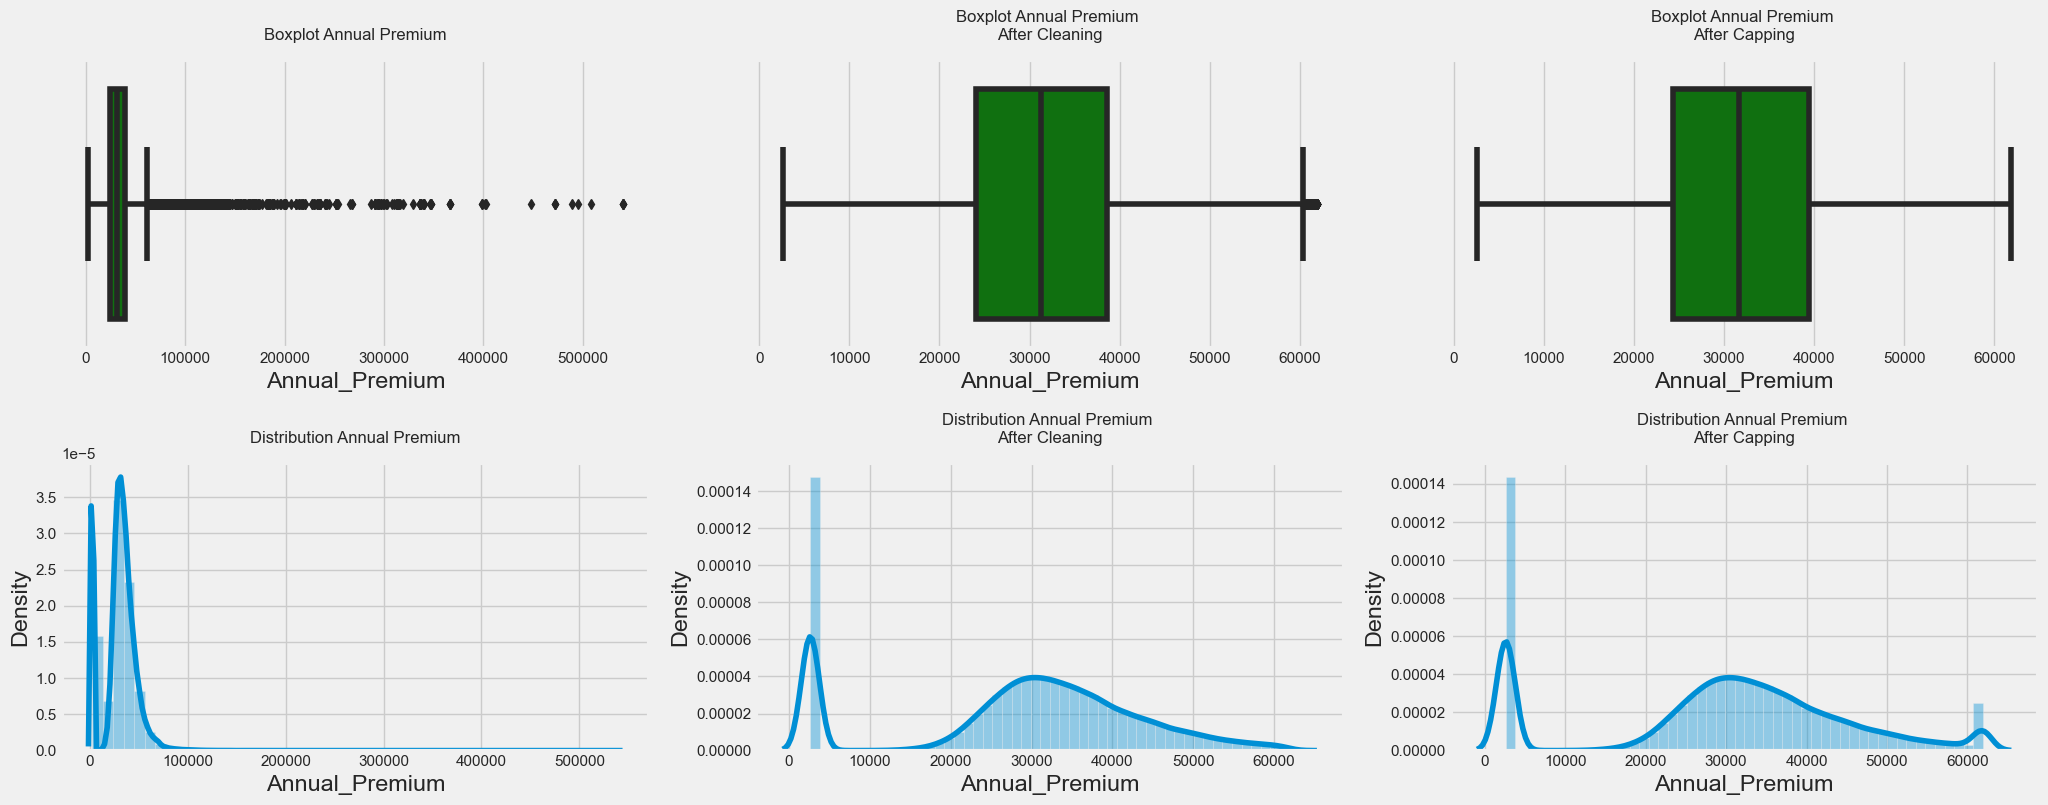

In [12]:
fig, ax = plt.subplots(2,3)

sns.boxplot(x=df['Annual_Premium'], color='green',orient='h',ax=ax[0,0])
ax[0,0].set_title('Boxplot Annual Premium', fontsize=12, pad=15, ha='center')
sns.distplot(df['Annual_Premium'], kde=True,ax=ax[1,0])
ax[1,0].set_title('Distribution Annual Premium', fontsize=12, pad=15, ha='center')

sns.boxplot(x=df_clean['Annual_Premium'], color='green',orient='h',ax=ax[0,1])
ax[0,1].set_title('Boxplot Annual Premium \nAfter Cleaning', fontsize=12, pad=15, ha='center')
sns.distplot(df_clean['Annual_Premium'], kde=True,ax=ax[1,1])
ax[1,1].set_title('Distribution Annual Premium \nAfter Cleaning', fontsize=12, pad=15, ha='center')

sns.boxplot(x=df_cap['Annual_Premium'], color='green',orient='h',ax=ax[0,2])
ax[0,2].set_title('Boxplot Annual Premium \nAfter Capping', fontsize=12, pad=15, ha='center')
sns.distplot(df_cap['Annual_Premium'], kde=True,ax=ax[1,2])
ax[1,2].set_title('Distribution Annual Premium \nAfter Capping', fontsize=12, pad=15, ha='center')

plt.tight_layout()

Diputuskan untuk tetap menggunakan dataframe df karena, kolom `Annual_Premium` merupakan hal yang normal jika terdapat outliers sehingga tidak dilakukan penghapusan outliers. Hal ini juga didasarkan dengan pertimbangan pembuatan model yang robust terhadap outliers.

## Feature encoding

Mengubah `Vehicle_Damage` ke integer dalam = 0: Kendaraan customer belum pernah rusak, 1: Kendaraan customer sudah pernah rusak, serta `Vehicle_Age` dam 0: < 1 Year, 1: 1-2 Years, 2: > 2 Years. Serta `Gender` dengan *One Hot Encoding*. Melakukan konversi ke angka mulai dari 0 untuk memudahkan kerja machine learning. Mengubah kolom dengan datatype bool ke int agar lebih mudah diproses oleh model.

In [13]:
for i in ['Gender']:
    onehots = pd.get_dummies(df['Gender'], prefix='Gen')
    df = df.join(onehots)

df[['Gen_Female','Gen_Male']] = df[['Gen_Female','Gen_Male']].astype(int)

In [14]:
mapping_damage = {'Yes' : 1, 'No' : 0}
df['Vehicle_Damage'] = df['Vehicle_Damage'].map(mapping_damage)


In [15]:
mapping_age = {'> 2 Years' : 2, '1-2 Year' : 1, '< 1 Year' : 0}
df['Vehicle_Age'] = df['Vehicle_Age'].map(mapping_age)

In [16]:
df.sample(2, random_state=42)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gen_Female,Gen_Male
200222,200223,Female,21,1,3.0,1,0,0,20408.0,160.0,72,0,1,0
49766,49767,Male,55,1,15.0,0,1,1,37498.0,26.0,102,0,0,1


## Class Imbalance

In [17]:
# Melihat berapa dejarat ketimpangan pada class

for i in range(len(df['Response'].value_counts())):
    a = round(df['Response'].value_counts()[i]/df.shape[0]*100,2)
    print(f'{a}%')

print('Degree of Imbalance dari data ini termasuk pada Moderate Imbalance')

87.74%
12.26%
Degree of Imbalance dari data ini termasuk pada Moderate Imbalance


Penanganan Class Imbalance dilakukan dengan ***undersampling*** dengan pertimbangan agar data tidak cenderung bias, dimana selisih antara kedua value 0 dan 1 lebih dari 50% sehingga jika dilakukan *oversampling* tidak menjamin akan adanya peningkatan performansi machine learning.

In [18]:
# Membuat kolom baru untuk melihat Class 'Yes'

df['Res_class'] = df['Response']==1
df['Res_class'].value_counts()

Res_class
False    334399
True      46710
Name: count, dtype: int64

In [19]:
# Memisahkan dataframe dengan Response dan Res_class dan hanya Res_class
X = df[[col for col in df.columns if (str(df[col].dtype) != 'object') and col not in ['Response', 'Res_class']]]
y = df['Res_class'].values
print(X.shape)
print(y.shape)

(381109, 12)
(381109,)


In [20]:
X_under_SMOTE, y_under_SMOTE = under_sampling.RandomUnderSampler(sampling_strategy=1, random_state=42).fit_resample(X, y)

In [21]:
print('Original')
print(pd.Series(y).value_counts())
print('\n')
print('UNDERSAMPLING')
print('SMOTE')
print(pd.Series(y_under_SMOTE).value_counts())

Original
False    334399
True      46710
Name: count, dtype: int64


UNDERSAMPLING
SMOTE
False    46710
True     46710
Name: count, dtype: int64


In [22]:
X_under_SMOTE['Response'] = y_under_SMOTE.astype(int)
df = X_under_SMOTE.copy()

# Feature Engineering

## Feature Selection

In [23]:
df.drop(columns=['id'], axis=1, inplace=True)

<Axes: >

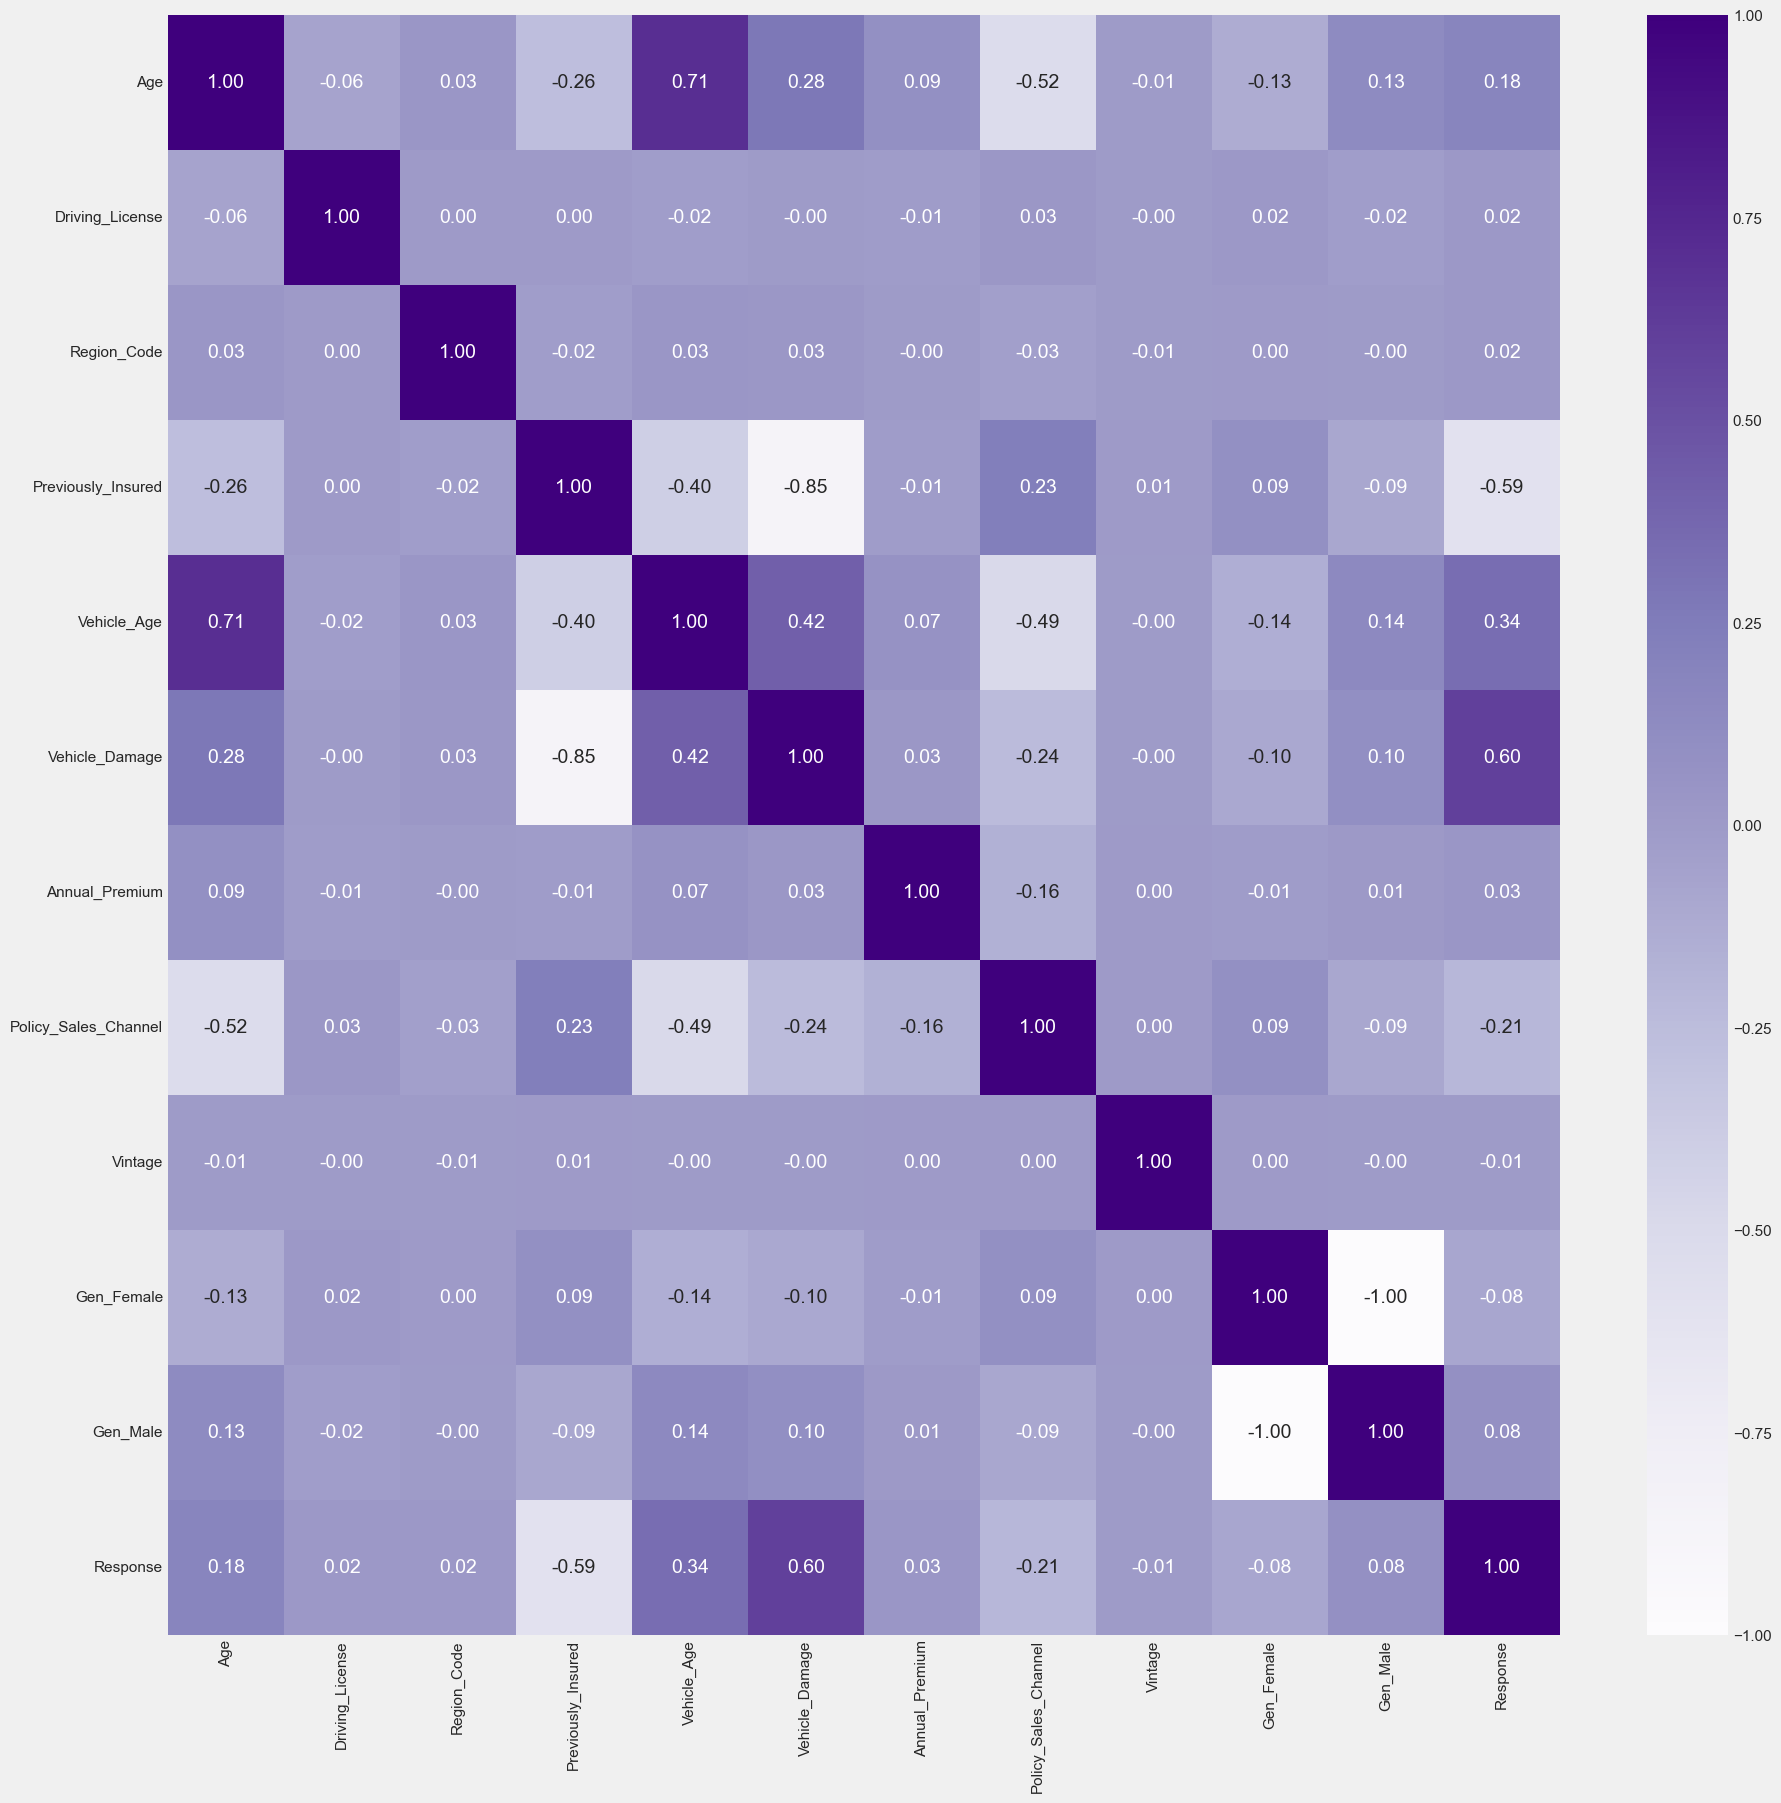

In [24]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), cmap='Purples', annot=True, fmt='.2f')

Dari heatmap dapat didapatkan insight bahwa, `Age` dan `Vehicle_Age` merupakan kolom redundant sehingga diputuskan untuk tidak menggunakan pada kolom `Age` dengan pertimbangan kolom `Age` memiliki korelasi lebih kecil dibandingkan `Vehicle_Age`.

## Feature Extraction

In [25]:
# Membuat fitur kategori baru dari Age dengan mengelompokkan YoungAdults 17 - 30, MiddleAged 31-45, OldAdults > 45
Age_Group = []
for i in df['Age']:
    if 17 <= i <=30:
        Age_Group.append(0)
    elif 31 <= i <= 45:
        Age_Group.append(1)
    else:
        Age_Group.append(2)

df['Age_Group'] = Age_Group
df

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gen_Female,Gen_Male,Response,Age_Group
79509,22,1,19.0,1,0,0,54559.0,152.0,87,1,0,0,0
186554,57,1,18.0,0,1,1,33439.0,124.0,63,0,1,0,2
158036,64,1,28.0,0,1,1,39327.0,122.0,45,1,0,0,2
343705,52,1,41.0,1,1,0,26536.0,124.0,161,0,1,0,2
137902,21,1,7.0,0,0,0,28416.0,152.0,92,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381057,40,1,46.0,0,1,1,27508.0,26.0,189,0,1,1,1
381061,41,1,28.0,0,1,1,37377.0,124.0,99,1,0,1,1
381073,46,1,28.0,0,1,1,34741.0,124.0,167,1,0,1,2
381075,61,1,28.0,0,1,1,43875.0,26.0,139,1,0,1,2


In [26]:
# Melakukan ekstrasi dari kolom Annual_Premium dengan LowPremium < 24406, MediumPremium 24406 - 61892.4 dan HighPremium > 61892.4
c = []

for i in df['Annual_Premium']:
    if i <=  24405:
        c.append(0)
    elif 24406 <= i <= 61892.4:
        c.append(1)
    else:
        c.append(2)

df['Premium_cat'] = c
df

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gen_Female,Gen_Male,Response,Age_Group,Premium_cat
79509,22,1,19.0,1,0,0,54559.0,152.0,87,1,0,0,0,1
186554,57,1,18.0,0,1,1,33439.0,124.0,63,0,1,0,2,1
158036,64,1,28.0,0,1,1,39327.0,122.0,45,1,0,0,2,1
343705,52,1,41.0,1,1,0,26536.0,124.0,161,0,1,0,2,1
137902,21,1,7.0,0,0,0,28416.0,152.0,92,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381057,40,1,46.0,0,1,1,27508.0,26.0,189,0,1,1,1,1
381061,41,1,28.0,0,1,1,37377.0,124.0,99,1,0,1,1,1
381073,46,1,28.0,0,1,1,34741.0,124.0,167,1,0,1,2,1
381075,61,1,28.0,0,1,1,43875.0,26.0,139,1,0,1,2,1


In [27]:
# Melakukan ekstrasi kolom Policy_Sales_Channel berdasarkan value_counts
p = df['Policy_Sales_Channel'].value_counts()
Policy_cat = p.apply(lambda x : 3 if x>=16455 else 2 if 8227<x<16455 else 1 if x<=8227 else 0)
Policy_cat = dict(zip(Policy_cat.keys(),Policy_cat.values))
df['Policy_cat'] = df['Policy_Sales_Channel'].map(Policy_cat)
df

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gen_Female,Gen_Male,Response,Age_Group,Premium_cat,Policy_cat
79509,22,1,19.0,1,0,0,54559.0,152.0,87,1,0,0,0,1,3
186554,57,1,18.0,0,1,1,33439.0,124.0,63,0,1,0,2,1,3
158036,64,1,28.0,0,1,1,39327.0,122.0,45,1,0,0,2,1,1
343705,52,1,41.0,1,1,0,26536.0,124.0,161,0,1,0,2,1,3
137902,21,1,7.0,0,0,0,28416.0,152.0,92,1,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381057,40,1,46.0,0,1,1,27508.0,26.0,189,0,1,1,1,1,3
381061,41,1,28.0,0,1,1,37377.0,124.0,99,1,0,1,1,1,3
381073,46,1,28.0,0,1,1,34741.0,124.0,167,1,0,1,2,1,3
381075,61,1,28.0,0,1,1,43875.0,26.0,139,1,0,1,2,1,3


In [28]:
# Melakukan ekstrasi kolom Region_Code berdasarkan value_counts
r = df['Region_Code'].value_counts()
Region_cat = r.apply(lambda x : 2 if x > 8339 else 1 if 2611<=x<=8339 else 0)
Region_cat = dict(zip(Region_cat.keys(),Region_cat.values))
df['Region_cat'] = df['Region_Code'].map(Region_cat)
df

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gen_Female,Gen_Male,Response,Age_Group,Premium_cat,Policy_cat,Region_cat
79509,22,1,19.0,1,0,0,54559.0,152.0,87,1,0,0,0,1,3,0
186554,57,1,18.0,0,1,1,33439.0,124.0,63,0,1,0,2,1,3,0
158036,64,1,28.0,0,1,1,39327.0,122.0,45,1,0,0,2,1,1,2
343705,52,1,41.0,1,1,0,26536.0,124.0,161,0,1,0,2,1,3,1
137902,21,1,7.0,0,0,0,28416.0,152.0,92,1,0,0,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381057,40,1,46.0,0,1,1,27508.0,26.0,189,0,1,1,1,1,3,1
381061,41,1,28.0,0,1,1,37377.0,124.0,99,1,0,1,1,1,3,2
381073,46,1,28.0,0,1,1,34741.0,124.0,167,1,0,1,2,1,3,2
381075,61,1,28.0,0,1,1,43875.0,26.0,139,1,0,1,2,1,3,2


<Axes: >

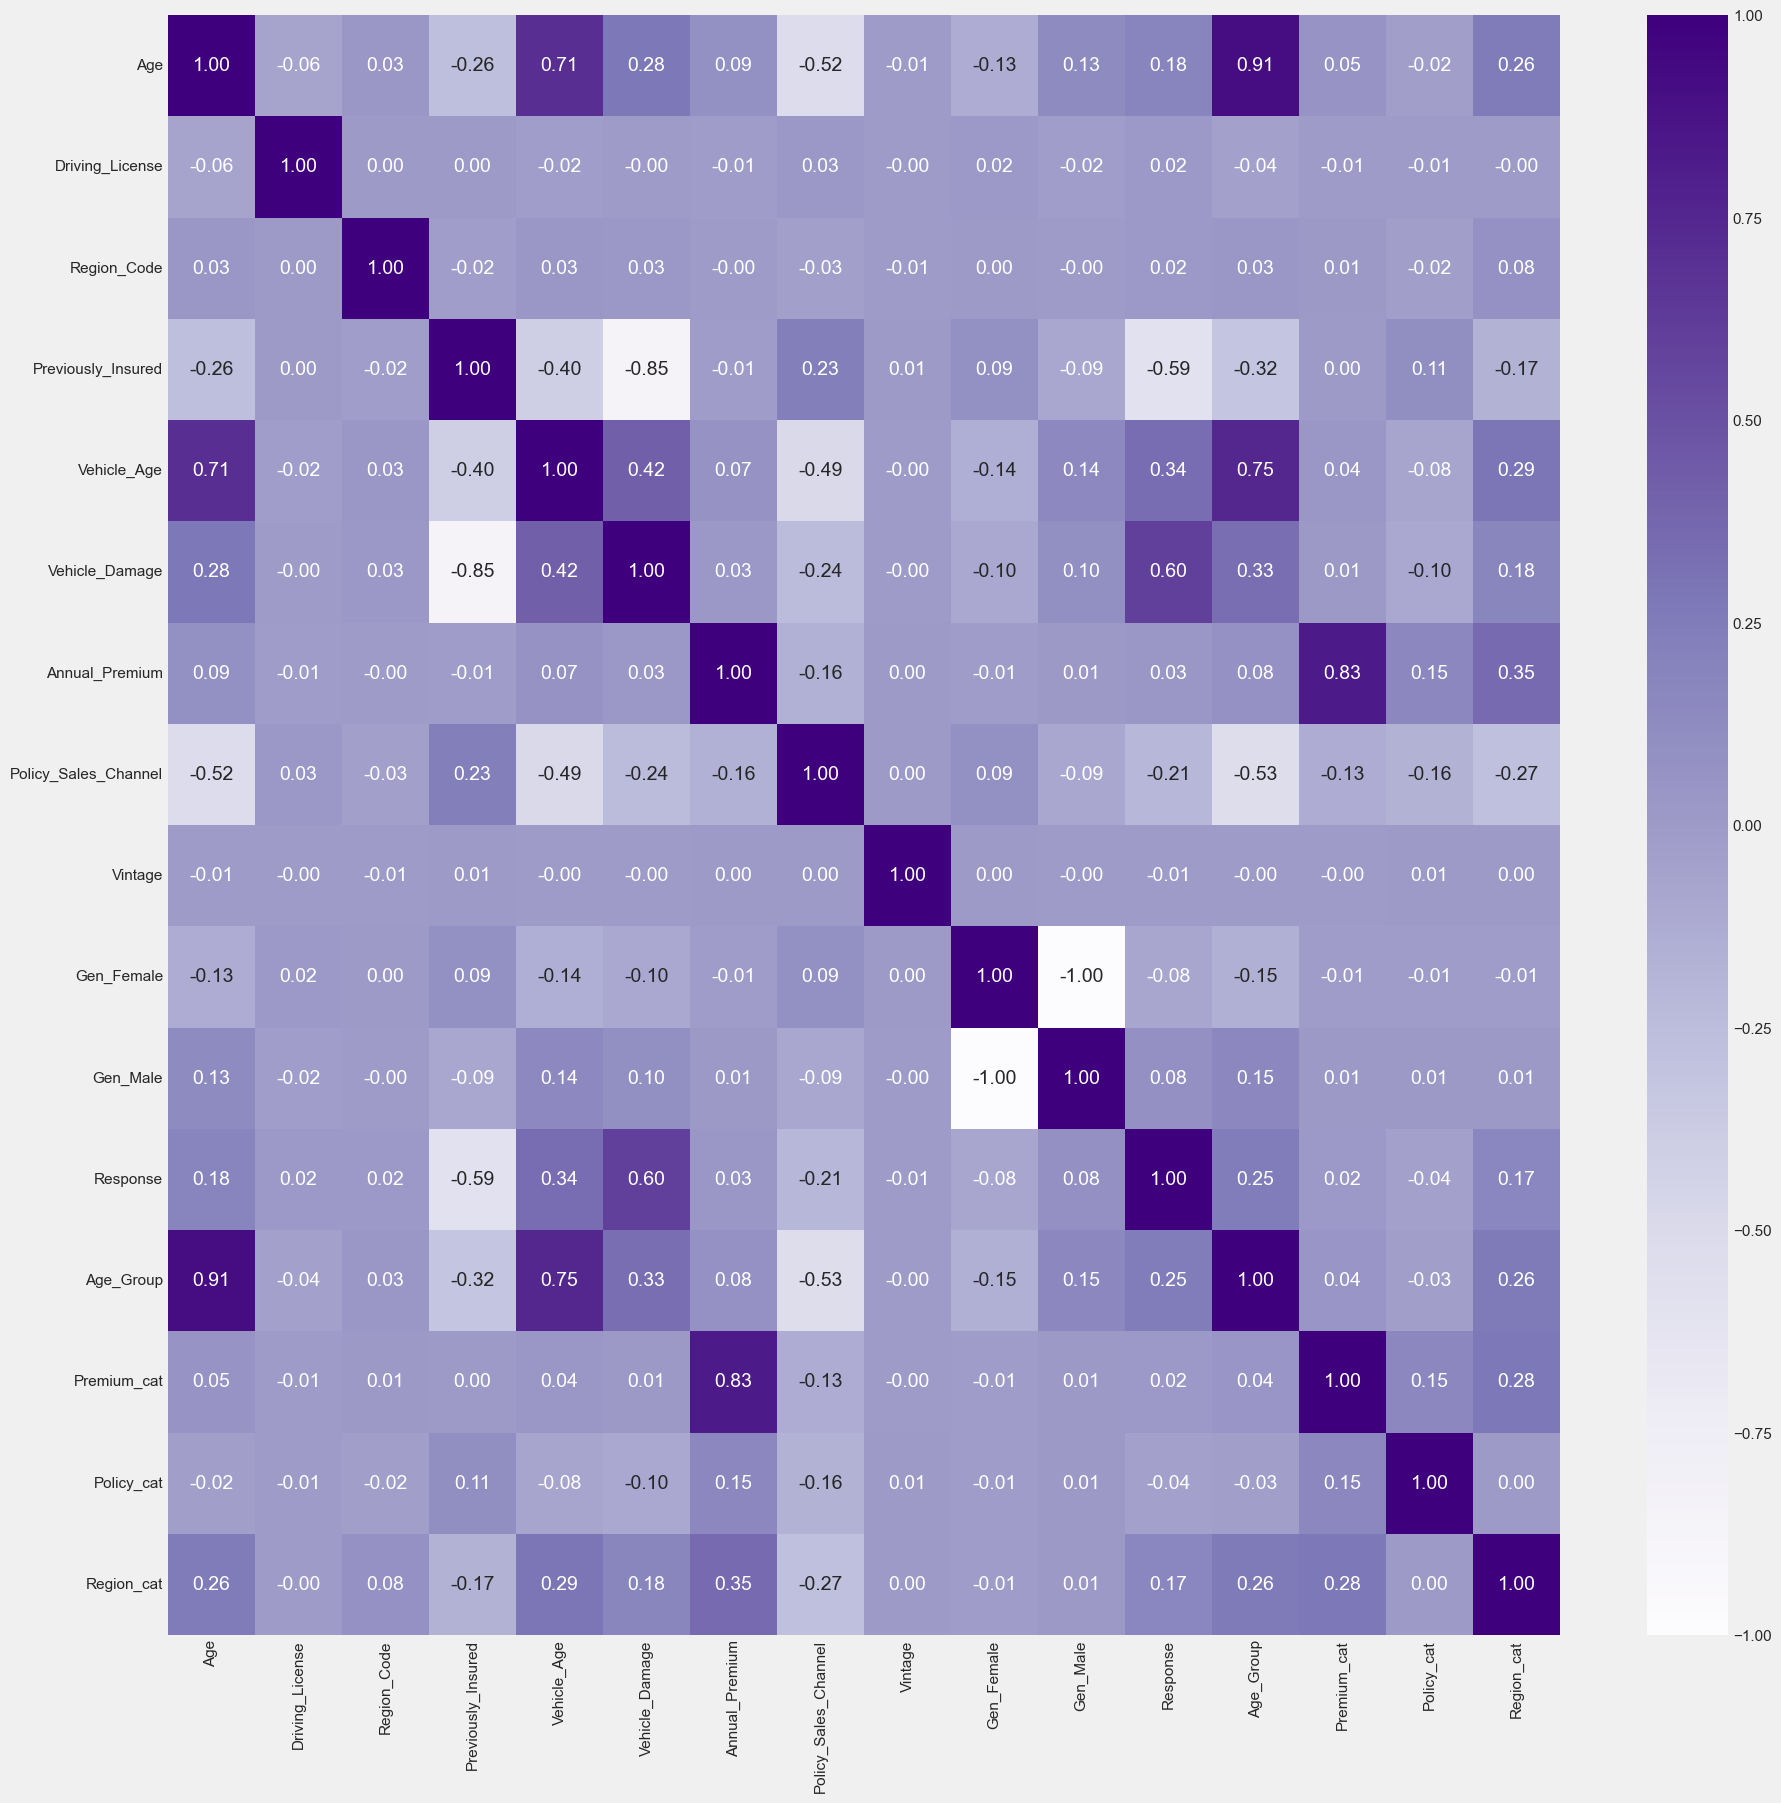

In [29]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), cmap='Purples', annot=True, fmt='.2f')

Dari hasil *feature extraction* didapatkan insight bahwa `Policy_cat` tidak memiliki korelasi dengan `Response`, sedangkan `Age_Group` dan `Premium_cat` memiliki korelasi *positive*.

## 4 New Features

1. `Premium_Per_Channel`, untuk menghitung dan memberi insight baru mengenai total premium dari berbagai `Policy_Sales_Channel` dengan begitu pengelompokkan Channel dapat dilakukan berdasarkan `Annual_Premium`.

2. `Vintage_Group`, feature baru yang mengubah feature `Vintage` menjadi kategori dengan range tertentu dimana diartikan menjadi New (baru bergabung), Intermediate (sudah bergabung cukup lama), Long-term (sudah bergabung lama).

3. `Not_Insured_and_Damaged`, kolom yang berisikan nilai 1 jika kolom `Previously_Insured` memiliki value 0 dan `Vehicle_Damage` memiliki value 1.

4. `Channel_Response_Rate`, merupakan rate respon dari tiap channel dimana menindikasikan seberapa efektif suatu channel untuk mendapatkan jawaban 'Yes' dari sini juga dapat dilakukan pengelompokkan Channels yang memiliki rate tinggi.

## Feature Transformation

Data memiliki karakteristik mayoritas sudah berbentuk Gaussian namun ada beberapa yang masih belum tersebar normal.

In [30]:
# Mengkelompokkan kolom-kolom yang akan menjadi features serta target
x = ['int64', 'int32', 'int16', 'float64', 'float32', 'float16']
x = df.select_dtypes(include=x)
x.drop(columns=['Response'],inplace=True)
y = df['Response']

In [31]:
# Melakukan split test and train
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=1/3, random_state=42)

# Menggabungkan kembali features dan target untuk membuat dataframe test dan train

df_train = Xtrain.join(ytrain)
df_test  = Xtest.join(ytest)

Dari seluruh kolom yang bukan merupakan kolom kategori adalah `Age`, `Annual_Premium` dan `Vintage` sehingga hanya ketiga kolom ini yang dilakukan transformasi.

In [32]:
f_log = ['Age']
for i in f_log:
    df_train['log_'+i] = np.log(df_train[i] + (df_train[df_train[i] > 0][i].min() / 2))
    df_test['log_'+i] = np.log(df_test[i] + (df_test[df_test[i] > 0][i].min() / 2))

In [33]:
sscale = ['Annual_Premium','Vintage']
scaler = StandardScaler()
for i in sscale:
    scaler.fit(df_train[[i]])
    scaler.fit(df_test[[i]])
    df_train['std_'+i] = scaler.transform(df_train[[i]])
    df_test['std_'+i] = scaler.transform(df_test[[i]])

In [34]:
sscale = ['Annual_Premium','Vintage']
for i in sscale:
    df_train['box_'+i],_ = boxcox(df_train[i]+1)
    df_test['box_'+i],_ = boxcox(df_test[i]+1)

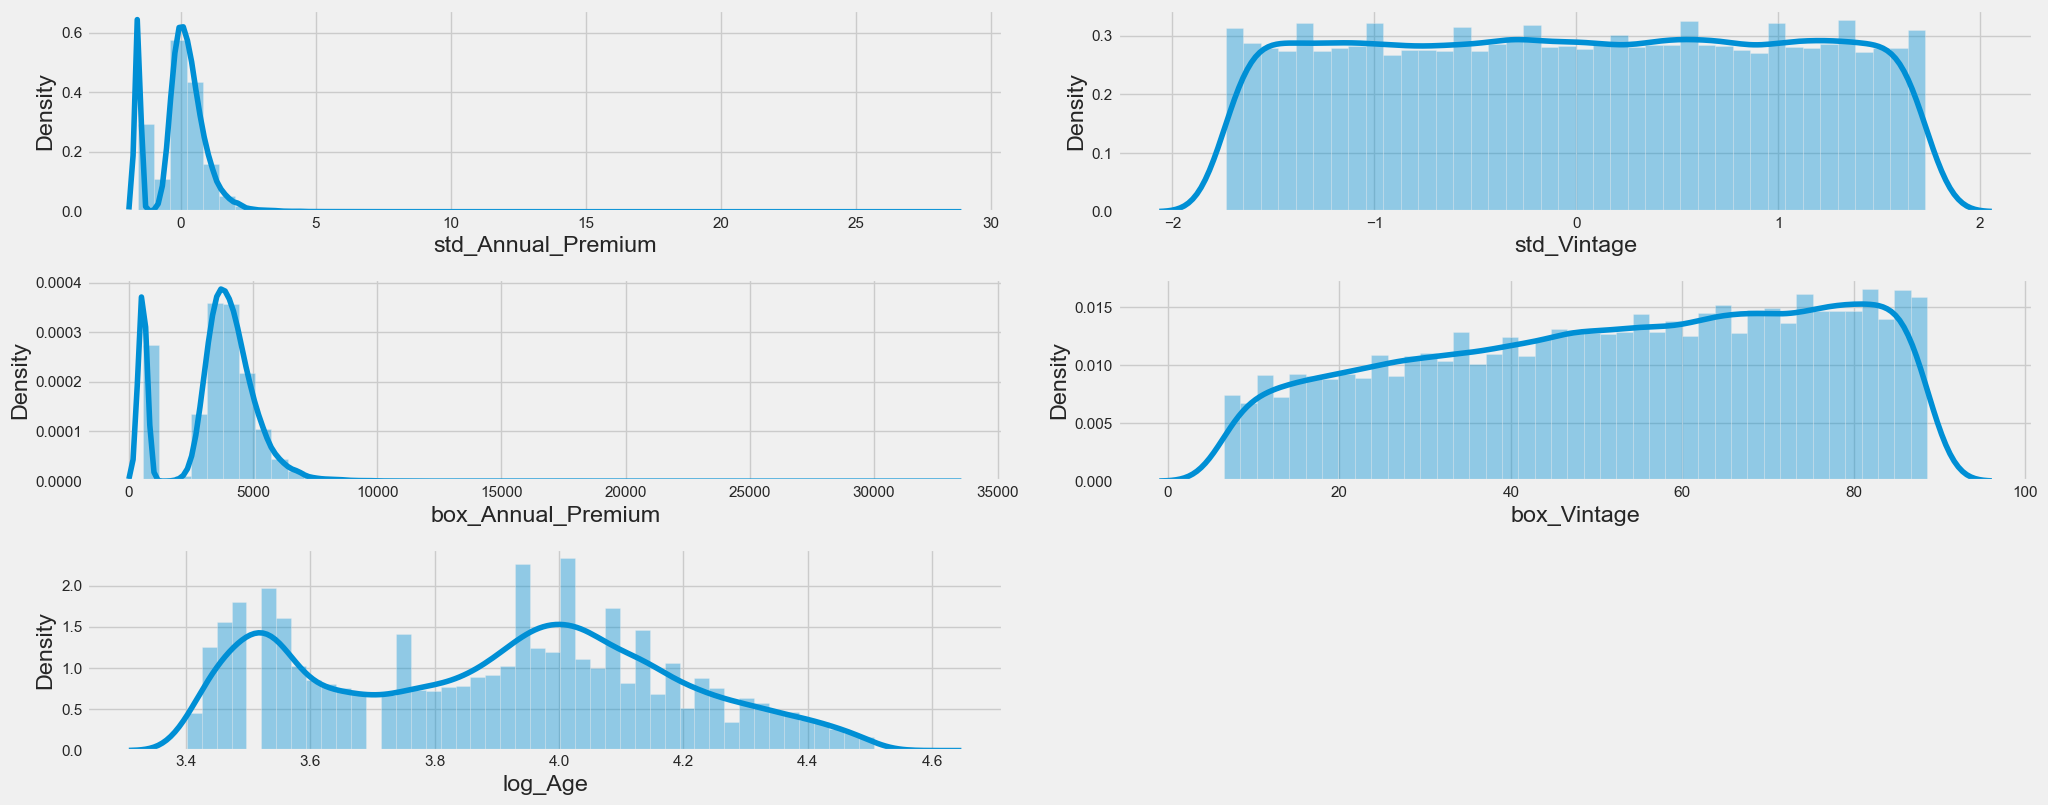

In [35]:
nums_std = ['std_Annual_Premium', 'std_Vintage', 'box_Annual_Premium', 'box_Vintage', 'log_Age']

k = int((len(nums_std)+1)/3)

for i in range(0, len(nums_std)):
    plt.subplot(3, k, i+1)
    sns.distplot(df_train[nums_std[i]], kde=True)
    plt.tight_layout()

Diputuskan menggunakan `standardscaler`.

Features yang dipilih `Vehicle_Age`, `Vehicle_Damage`, `Previously_Insured`, `Gen_Female`, `Gen_Male`, `Age_Group`, `Region_cat`,`nml_Annual_Premium`.

Sedangkan targetnya adalah `Response`.

# Modelling

In [36]:
df = pd.concat([df_train, df_test])

In [37]:
features = ['Vehicle_Age','Vehicle_Damage','Previously_Insured','Gen_Female','Gen_Male','Age_Group','Region_cat','std_Annual_Premium']
target = ['Response']

X = df[features].copy()
y = df[target].copy()
X_train = df_train[features].copy()
y_train = df_train[target].copy()
X_test = df_test[features].copy()
y_test = df_test[target].copy()

In [38]:
def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    
    score = cross_validate(RandomForestClassifier(), X, y, cv=5, scoring='roc_auc', return_train_score=True)
    print('roc_auc (crossval train): '+ str(score['train_score'].mean()))
    print('roc_auc (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

lg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
ridge = Ridge()
lasso = Lasso()
elas = ElasticNet()
xgb = XGBClassifier()
rf = RandomForestClassifier()
lgb = LGBMClassifier()
grd = GradientBoostingClassifier()

### 1. Logistic Regression

In [39]:
lgmodel = lg.fit(X_train, y_train)
eval_classification(lgmodel)

Accuracy (Test Set): 0.79
Accuracy (Train Set): 0.78
Precision (Test Set): 0.71
Precision (Train Set): 0.71
Recall (Test Set): 0.98
Recall (Train Set): 0.98
F1-Score (Test Set): 0.82
F1-Score (Train Set): 0.82
roc_auc (test-proba): 0.82
roc_auc (train-proba): 0.82
roc_auc (crossval train): 0.9857616350408358
roc_auc (crossval test): 0.8023066834306212


In [40]:
y_pred_lg_prob = lgmodel.predict_proba(X_test)[:,1]
y_pred_lg = lgmodel.predict(X_test)

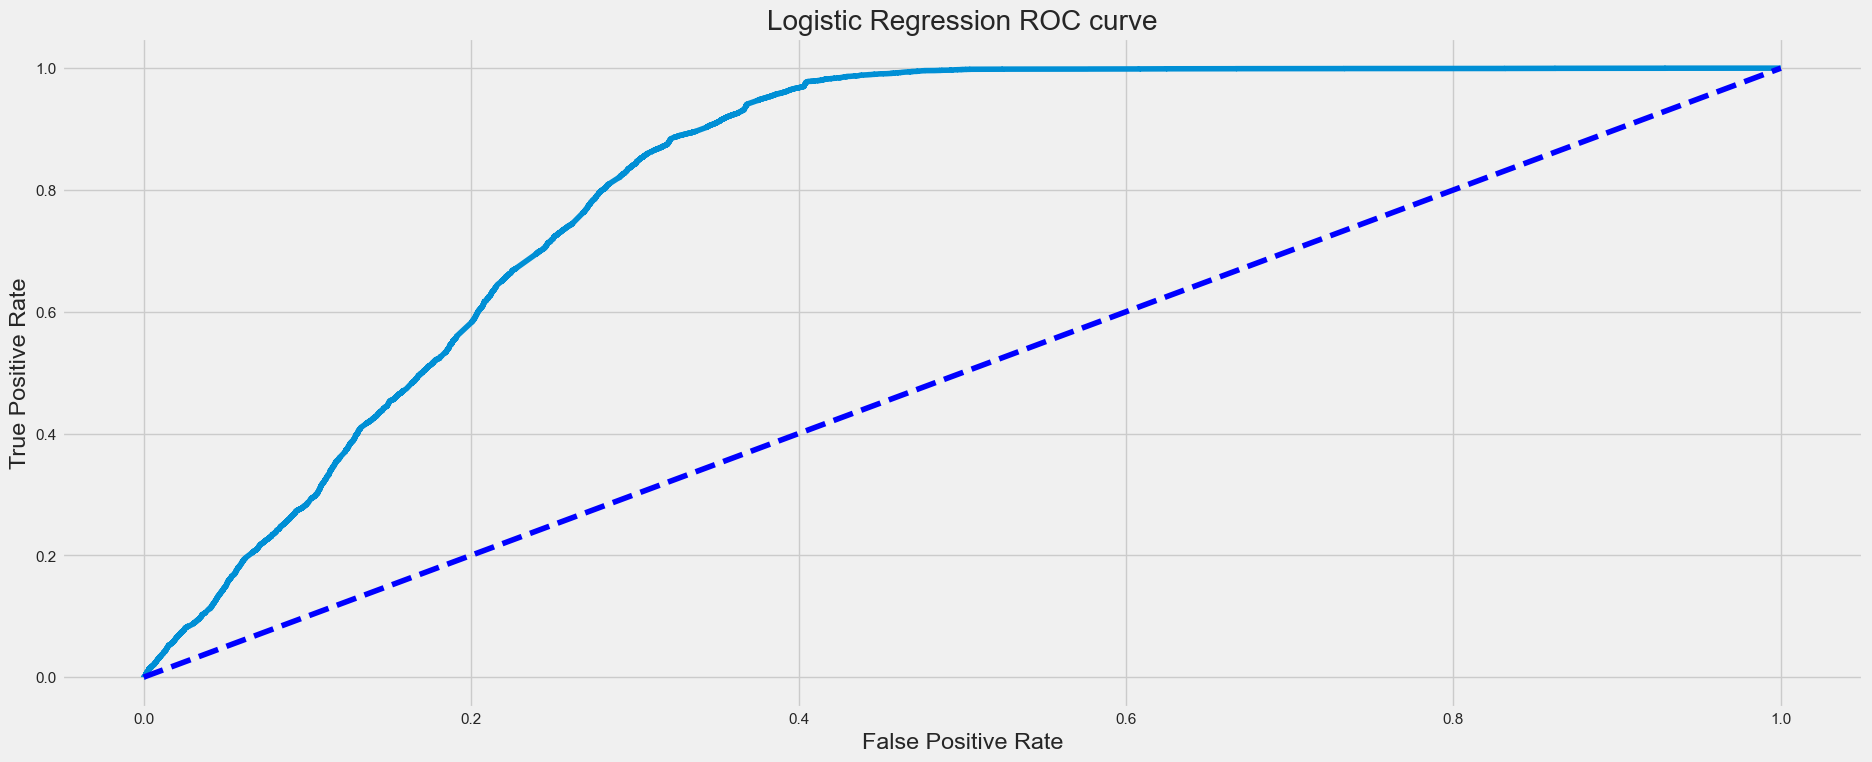

In [41]:
falposr, truposr, _ = roc_curve(y_test, y_pred_lg_prob)
plt.title('Logistic Regression ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[ 9296  6321]
 [  358 15165]]



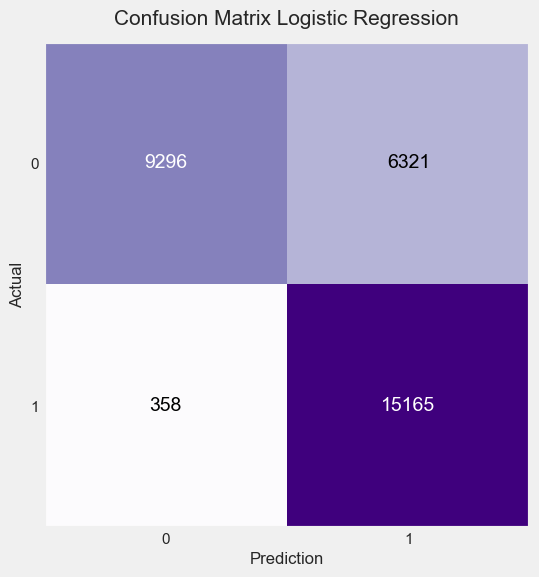

In [42]:
cmlg = confusion_matrix(y_test, y_pred_lg)
print(cmlg)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmlg, figsize=(6, 6), cmap=plt.cm.Purples)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Logistic Regression', fontsize=15, pad=12)
plt.show()

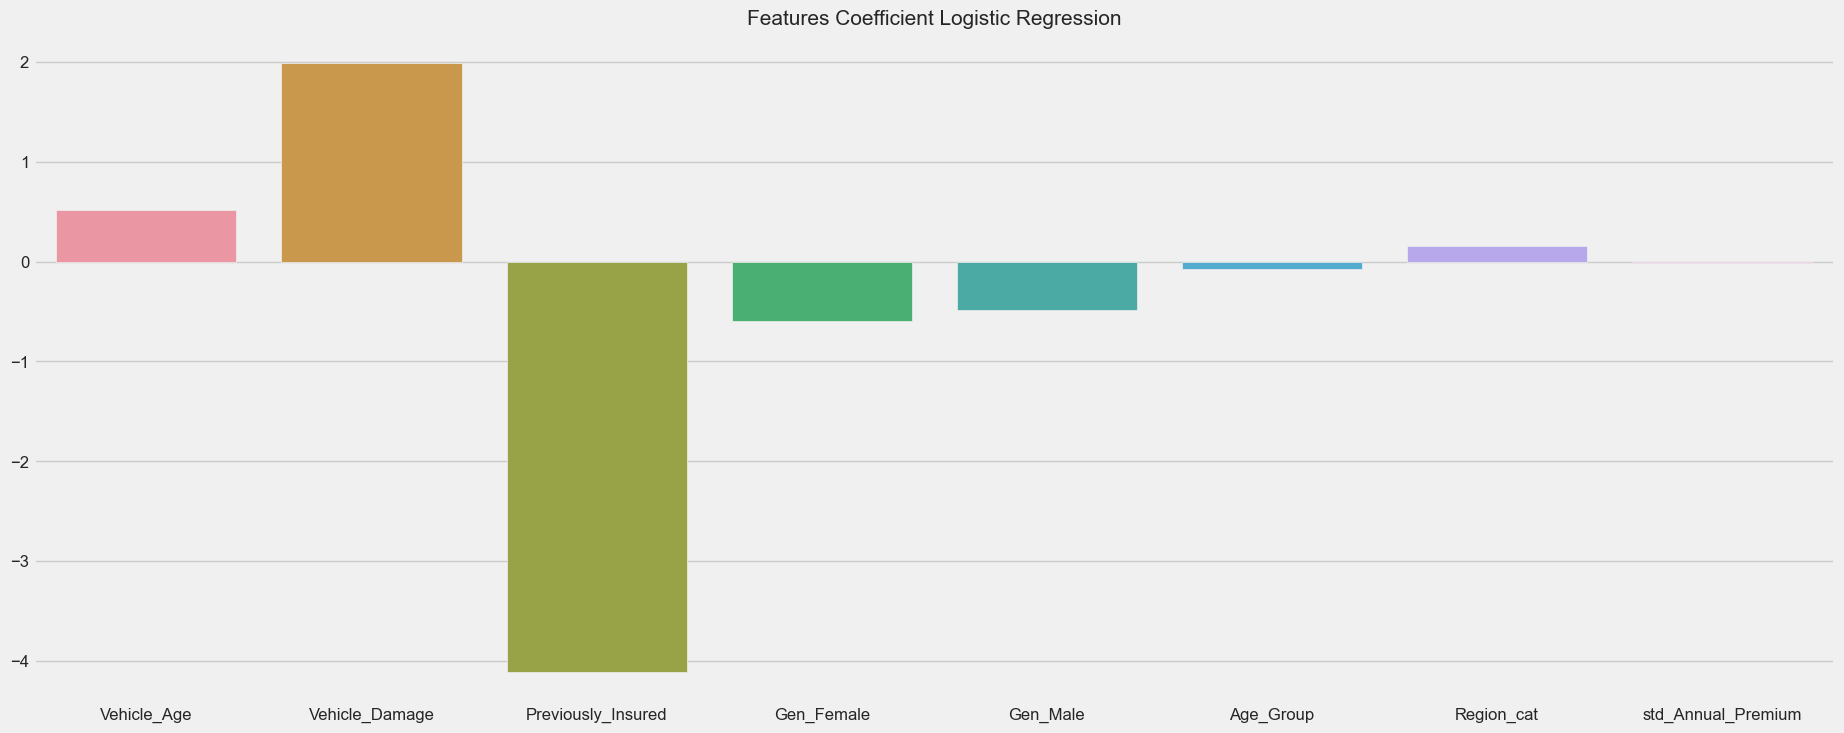

In [43]:
fi = pd.Series(lgmodel.coef_[0], index=df[features].columns)
sns.barplot(x=fi.index, y=fi.values)
plt.title('Features Coefficient Logistic Regression', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### 2. K-Nearest Neighbor

In [44]:
knnmodel = knn.fit(X_train, y_train)
eval_classification(knnmodel)

Accuracy (Test Set): 0.76
Accuracy (Train Set): 0.81
Precision (Test Set): 0.72
Precision (Train Set): 0.77
Recall (Test Set): 0.82
Recall (Train Set): 0.88
F1-Score (Test Set): 0.77
F1-Score (Train Set): 0.82
roc_auc (test-proba): 0.81
roc_auc (train-proba): 0.89
roc_auc (crossval train): 0.9857286859765644
roc_auc (crossval test): 0.8021368404538203


In [45]:
y_pred_knn_prob = knnmodel.predict_proba(X_test)[:,1]
y_pred_knn = knnmodel.predict(X_test)

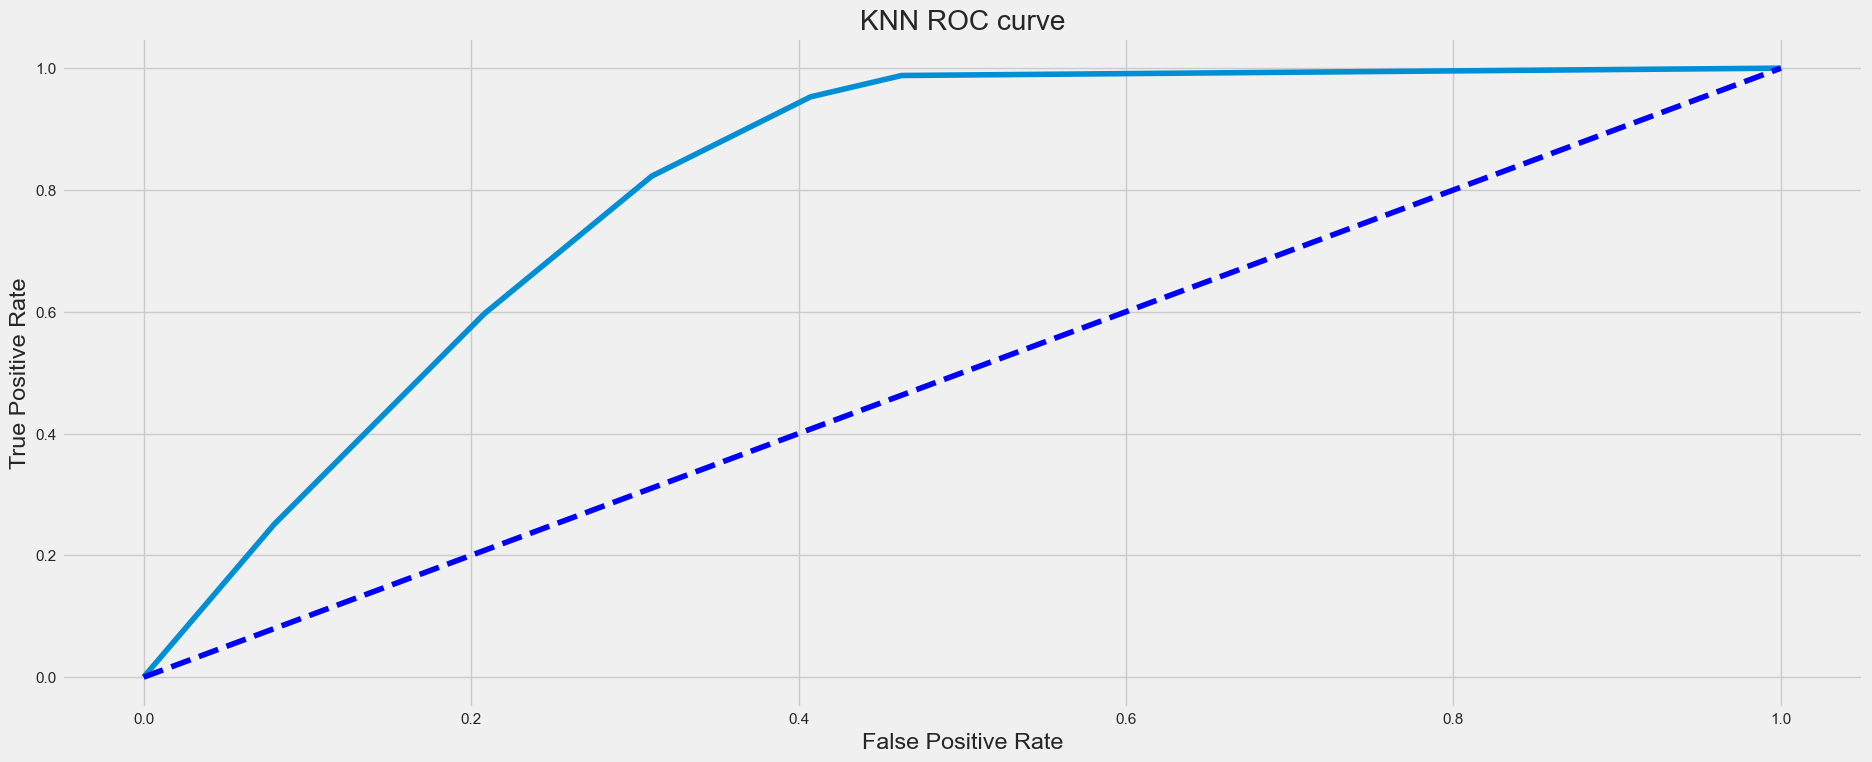

In [46]:
falposr, truposr, _ = roc_curve(y_test, y_pred_knn_prob)
plt.title('KNN ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[10770  4847]
 [ 2752 12771]]



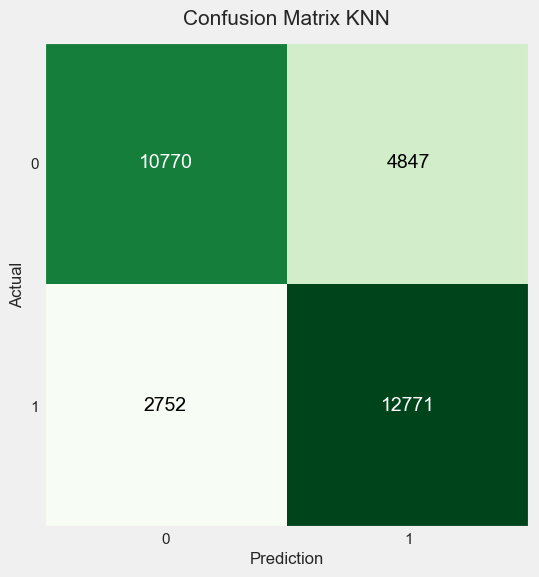

In [47]:
cmknn = confusion_matrix(y_test, y_pred_knn)
print(cmknn)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmknn, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix KNN', fontsize=15, pad=12)
plt.show()

### 3. Decision Tree

In [48]:
dtmodel = dt.fit(X_train, y_train)
eval_classification(dtmodel)

Accuracy (Test Set): 0.72
Accuracy (Train Set): 0.95
Precision (Test Set): 0.71
Precision (Train Set): 0.93
Recall (Test Set): 0.74
Recall (Train Set): 0.97
F1-Score (Test Set): 0.73
F1-Score (Train Set): 0.95
roc_auc (test-proba): 0.73
roc_auc (train-proba): 0.99
roc_auc (crossval train): 0.9857445469882288
roc_auc (crossval test): 0.8023003126145687


In [49]:
y_pred_dt_prob = dtmodel.predict_proba(X_test)[:,1]
y_pred_dt = dtmodel.predict(X_test)

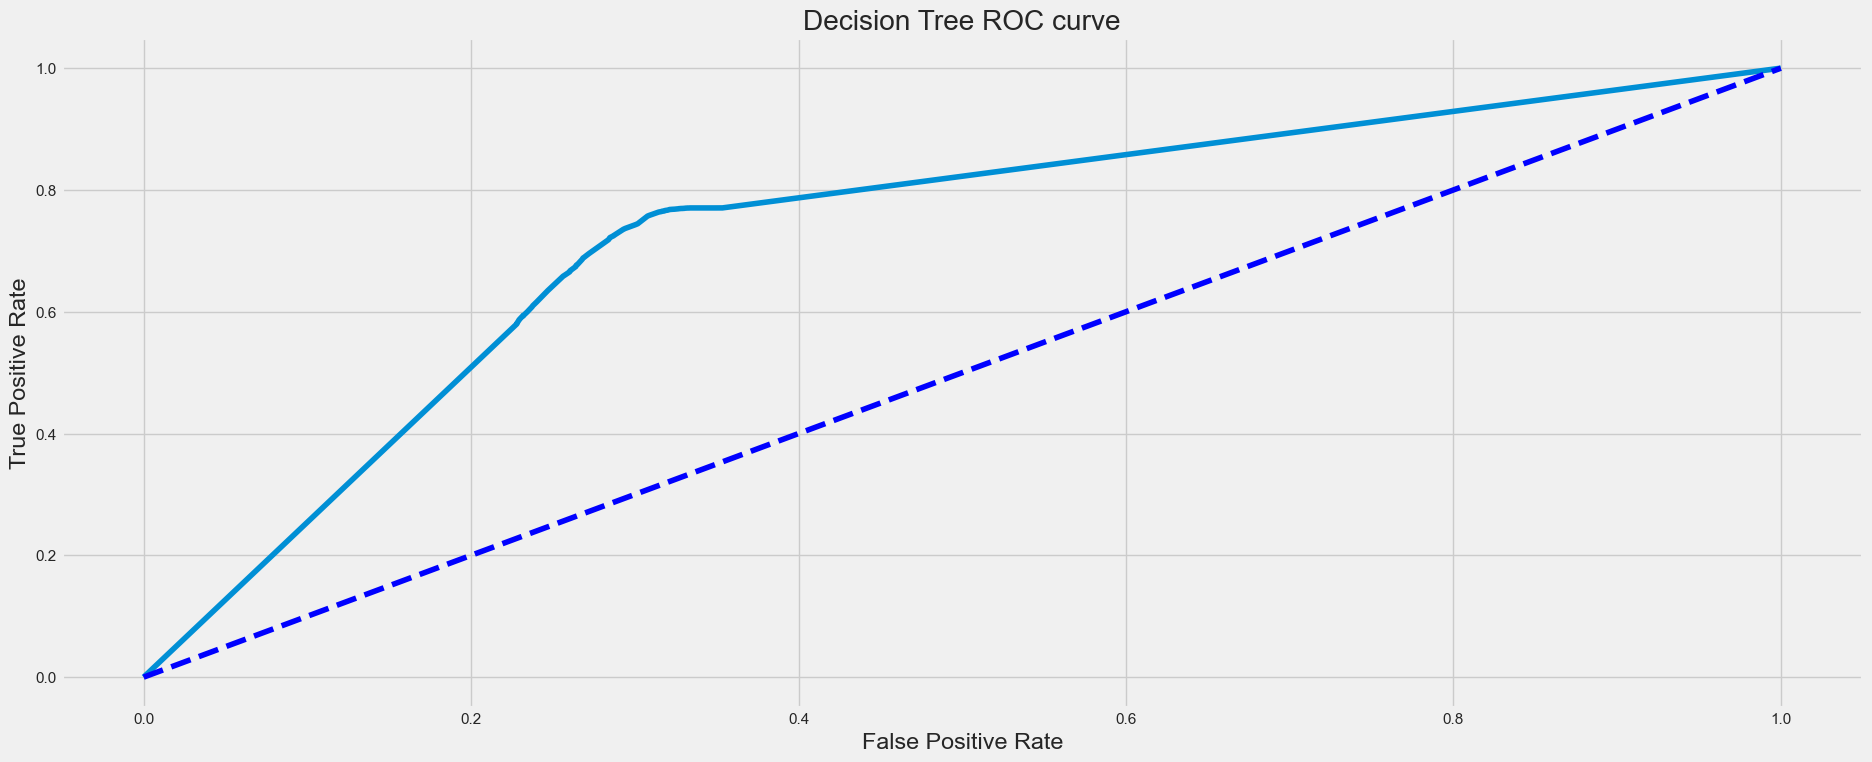

In [50]:
falposr, truposr, _ = roc_curve(y_test, y_pred_dt_prob)
plt.title('Decision Tree ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[10904  4713]
 [ 3965 11558]]



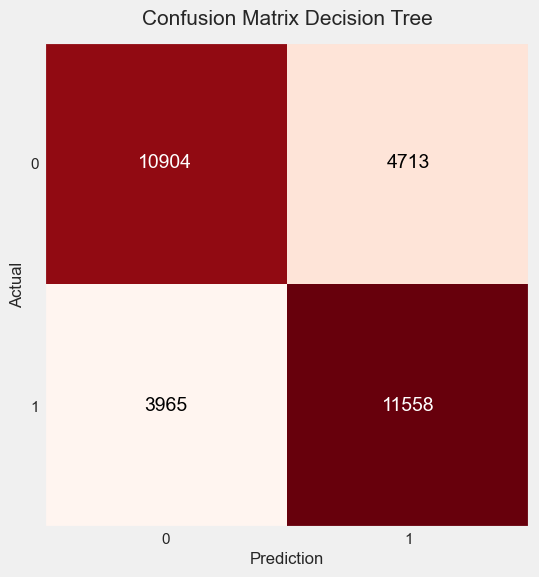

In [51]:
cmdt = confusion_matrix(y_test, y_pred_dt)
print(cmdt)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmdt, figsize=(6, 6), cmap=plt.cm.Reds)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Decision Tree', fontsize=15, pad=12)
plt.show()

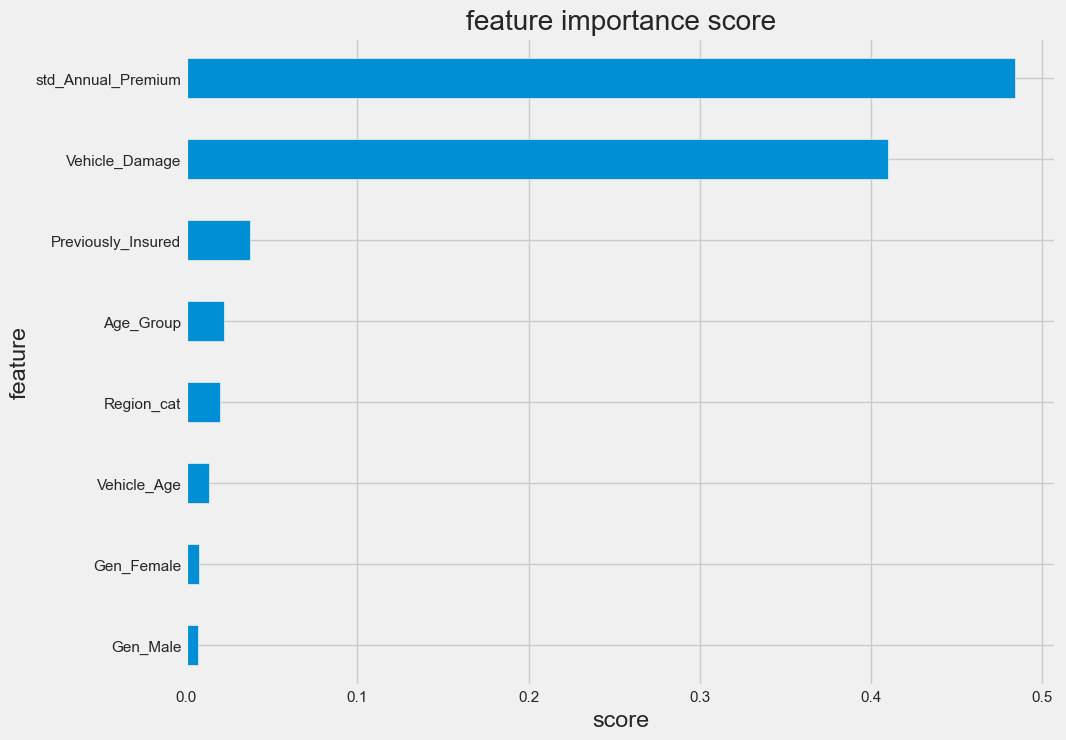

In [52]:
show_feature_importance(dtmodel)

### 4. XGBoost

In [53]:
xgmodel = xgb.fit(X_train, y_train)
eval_classification(xgmodel)

Accuracy (Test Set): 0.79
Accuracy (Train Set): 0.80
Precision (Test Set): 0.72
Precision (Train Set): 0.73
Recall (Test Set): 0.93
Recall (Train Set): 0.94
F1-Score (Test Set): 0.81
F1-Score (Train Set): 0.82
roc_auc (test-proba): 0.83
roc_auc (train-proba): 0.87
roc_auc (crossval train): 0.9857180970013808
roc_auc (crossval test): 0.802259734182971


In [54]:
y_pred_xg_prob = xgmodel.predict_proba(X_test)[:,1]
y_pred_xg = xgmodel.predict(X_test)

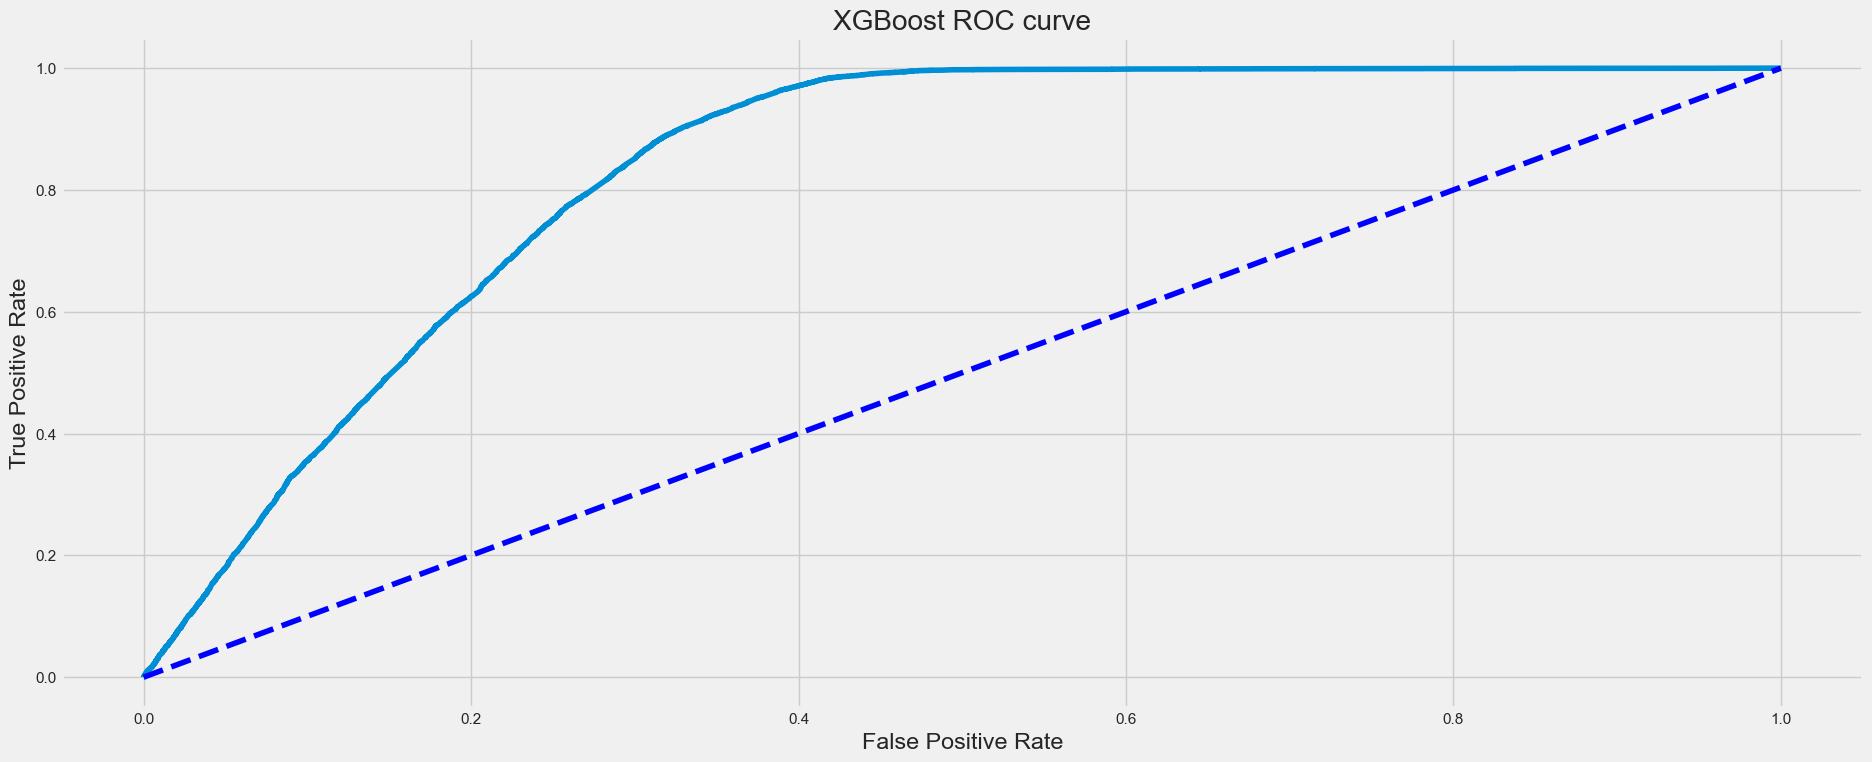

In [55]:
falposr, truposr, _ = roc_curve(y_test, y_pred_xg_prob)
plt.title('XGBoost ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[10131  5486]
 [ 1140 14383]]



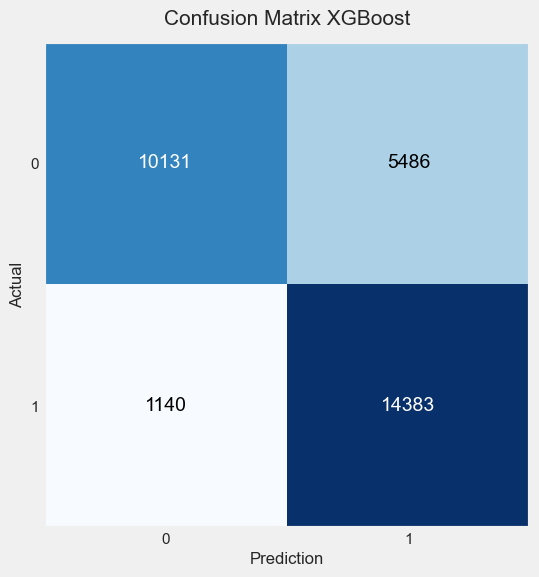

In [56]:
cmxg = confusion_matrix(y_test, y_pred_xg)
print(cmxg)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmxg, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix XGBoost', fontsize=15, pad=12)
plt.show()

### 5. Random Forest

In [57]:
rfmodel = rf.fit(X_train, y_train)
eval_classification(rfmodel)

Accuracy (Test Set): 0.73
Accuracy (Train Set): 0.95
Precision (Test Set): 0.71
Precision (Train Set): 0.92
Recall (Test Set): 0.76
Recall (Train Set): 0.98
F1-Score (Test Set): 0.73
F1-Score (Train Set): 0.95
roc_auc (test-proba): 0.80
roc_auc (train-proba): 0.99
roc_auc (crossval train): 0.9857462948806232
roc_auc (crossval test): 0.8024435093094808


In [58]:
y_pred_rf_prob = rfmodel.predict_proba(X_test)[:,1]
y_pred_rf = rfmodel.predict(X_test)

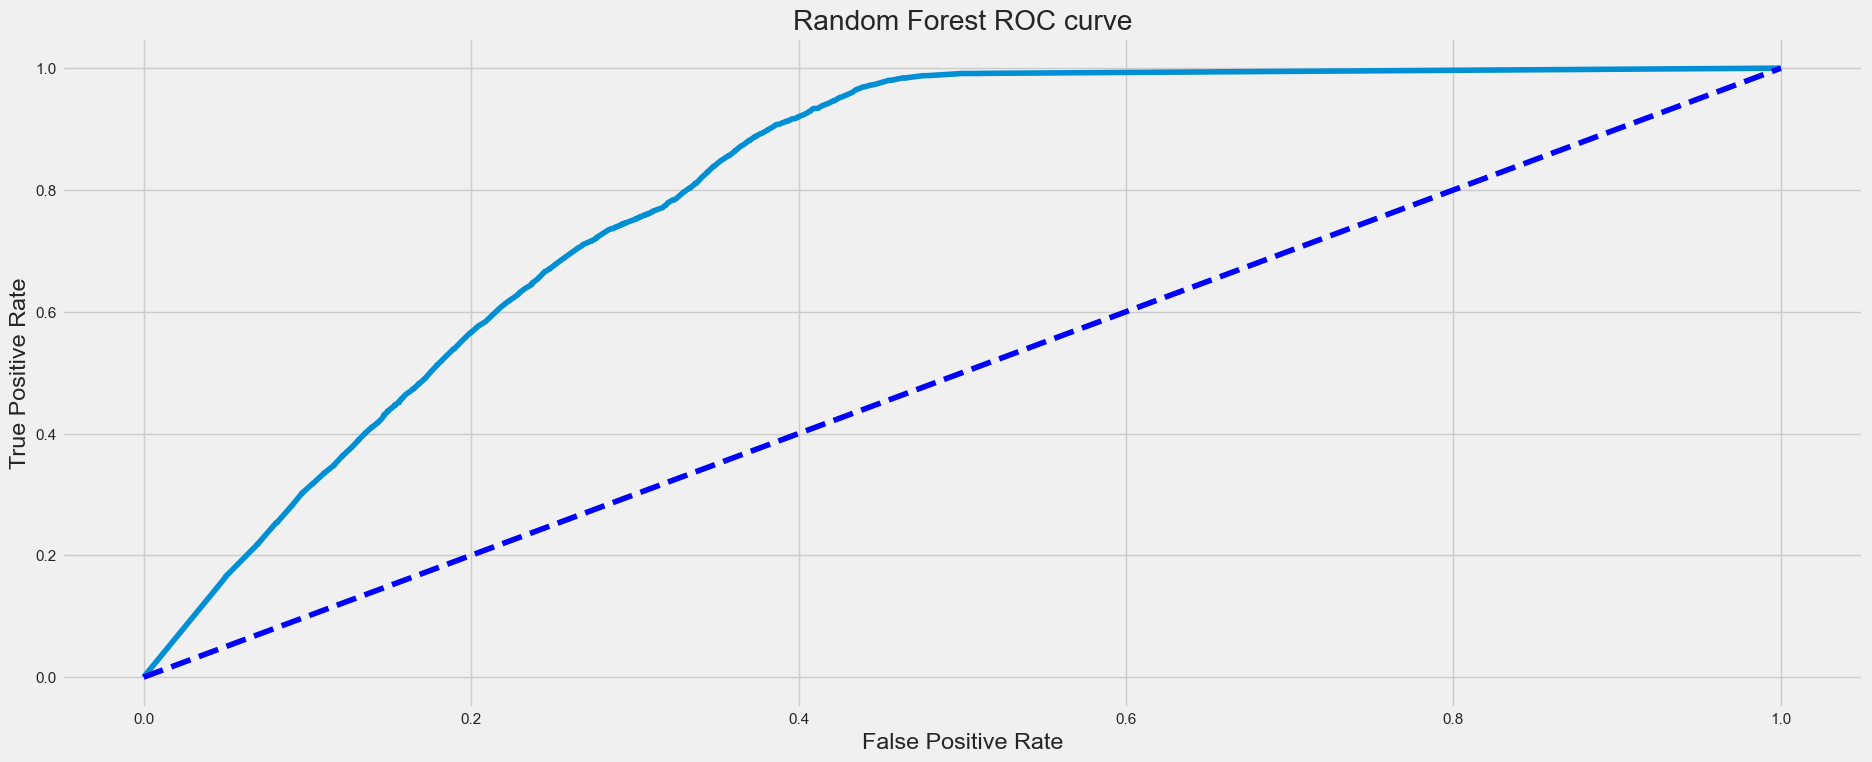

In [59]:
falposr, truposr, _ = roc_curve(y_test, y_pred_rf_prob)
plt.title('Random Forest ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[10837  4780]
 [ 3746 11777]]



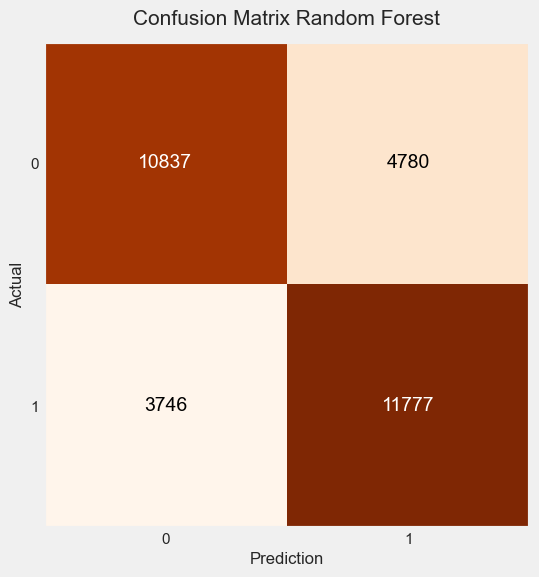

In [60]:
cmrf = confusion_matrix(y_test, y_pred_rf)
print(cmrf)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmrf, figsize=(6, 6), cmap=plt.cm.Oranges)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Random Forest', fontsize=15, pad=12)
plt.show()

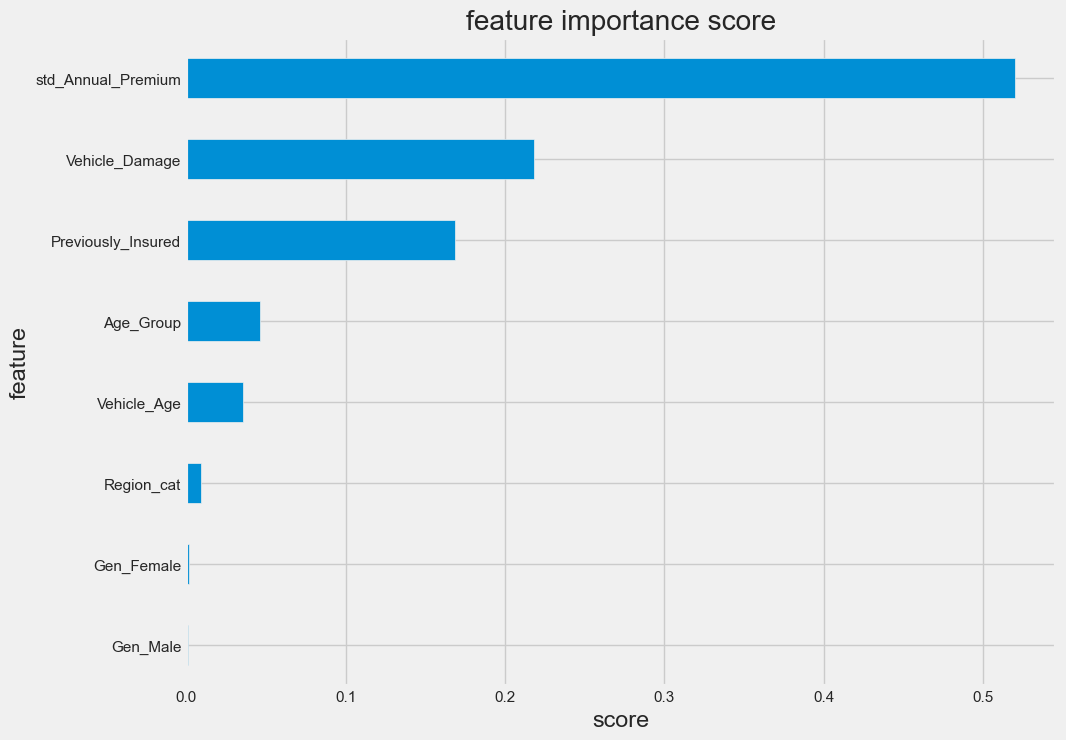

In [61]:
show_feature_importance(rfmodel)

### 6. LightGBM

In [62]:
lgbmodel = lgb.fit(X_train, y_train)
eval_classification(lgbmodel)

[LightGBM] [Info] Number of positive: 31187, number of negative: 31093
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 62280, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500755 -> initscore=0.003019
[LightGBM] [Info] Start training from score 0.003019
Accuracy (Test Set): 0.79
Accuracy (Train Set): 0.79
Precision (Test Set): 0.72
Precision (Train Set): 0.73
Recall (Test Set): 0.93
Recall (Train Set): 0.94
F1-Score (Test Set): 0.81
F1-Score (Train Set): 0.82
roc_auc (test-proba): 0.84
roc_auc (train-proba): 0.85
roc_auc (crossval train): 0.9858151281965167
roc_auc (crossval test): 0.8023633619227141


In [63]:
y_pred_lgb_prob = lgbmodel.predict_proba(X_test)[:,1]
y_pred_lgb = lgbmodel.predict(X_test)

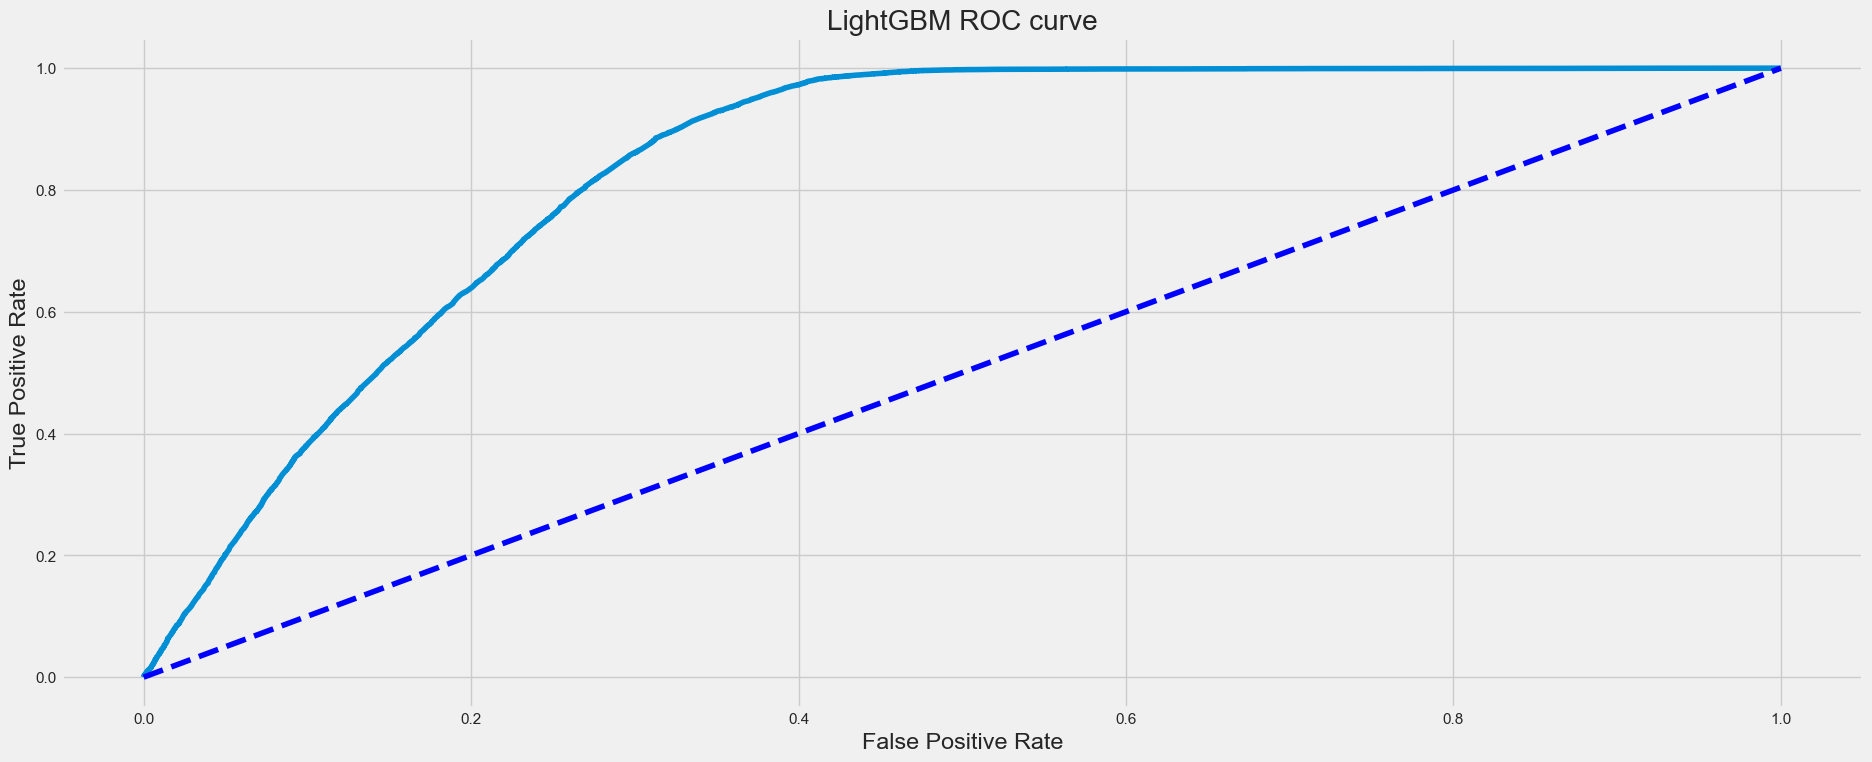

In [64]:
falposr, truposr, _ = roc_curve(y_test, y_pred_lgb_prob)
plt.title('LightGBM ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[10091  5526]
 [ 1062 14461]]



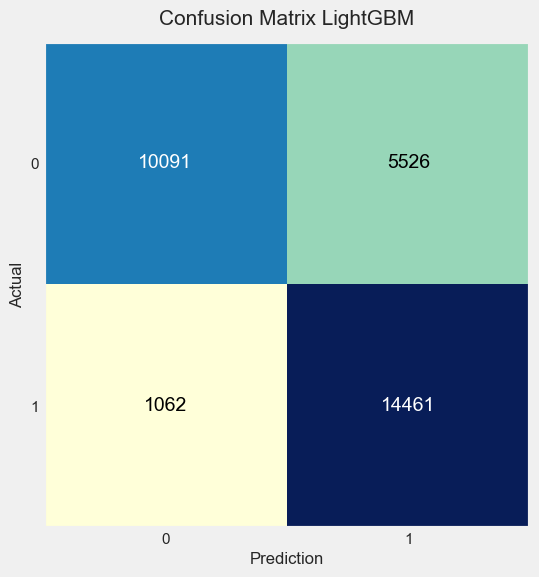

In [65]:
cmlgb = confusion_matrix(y_test, y_pred_lgb)
print(cmlgb)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmlgb, figsize=(6, 6), cmap=plt.cm.YlGnBu)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix LightGBM', fontsize=15, pad=12)
plt.show()

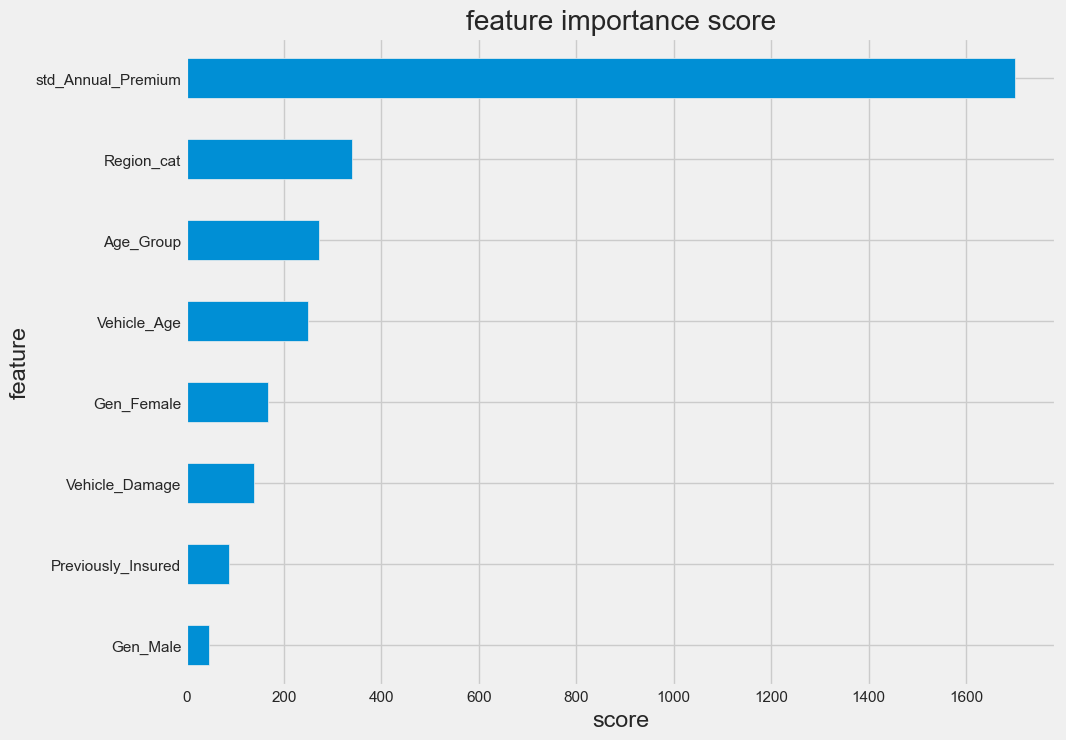

In [66]:
show_feature_importance(lgbmodel)

### 7. Gradient Boost

In [67]:
grdmodel = grd.fit(X_train, y_train)
eval_classification(grdmodel)

Accuracy (Test Set): 0.79
Accuracy (Train Set): 0.79
Precision (Test Set): 0.72
Precision (Train Set): 0.72
Recall (Test Set): 0.93
Recall (Train Set): 0.94
F1-Score (Test Set): 0.82
F1-Score (Train Set): 0.82
roc_auc (test-proba): 0.84
roc_auc (train-proba): 0.84
roc_auc (crossval train): 0.9857336343160064
roc_auc (crossval test): 0.802570391673646


In [68]:
y_pred_grd_prob = grdmodel.predict_proba(X_test)[:,1]
y_pred_grd = grdmodel.predict(X_test)

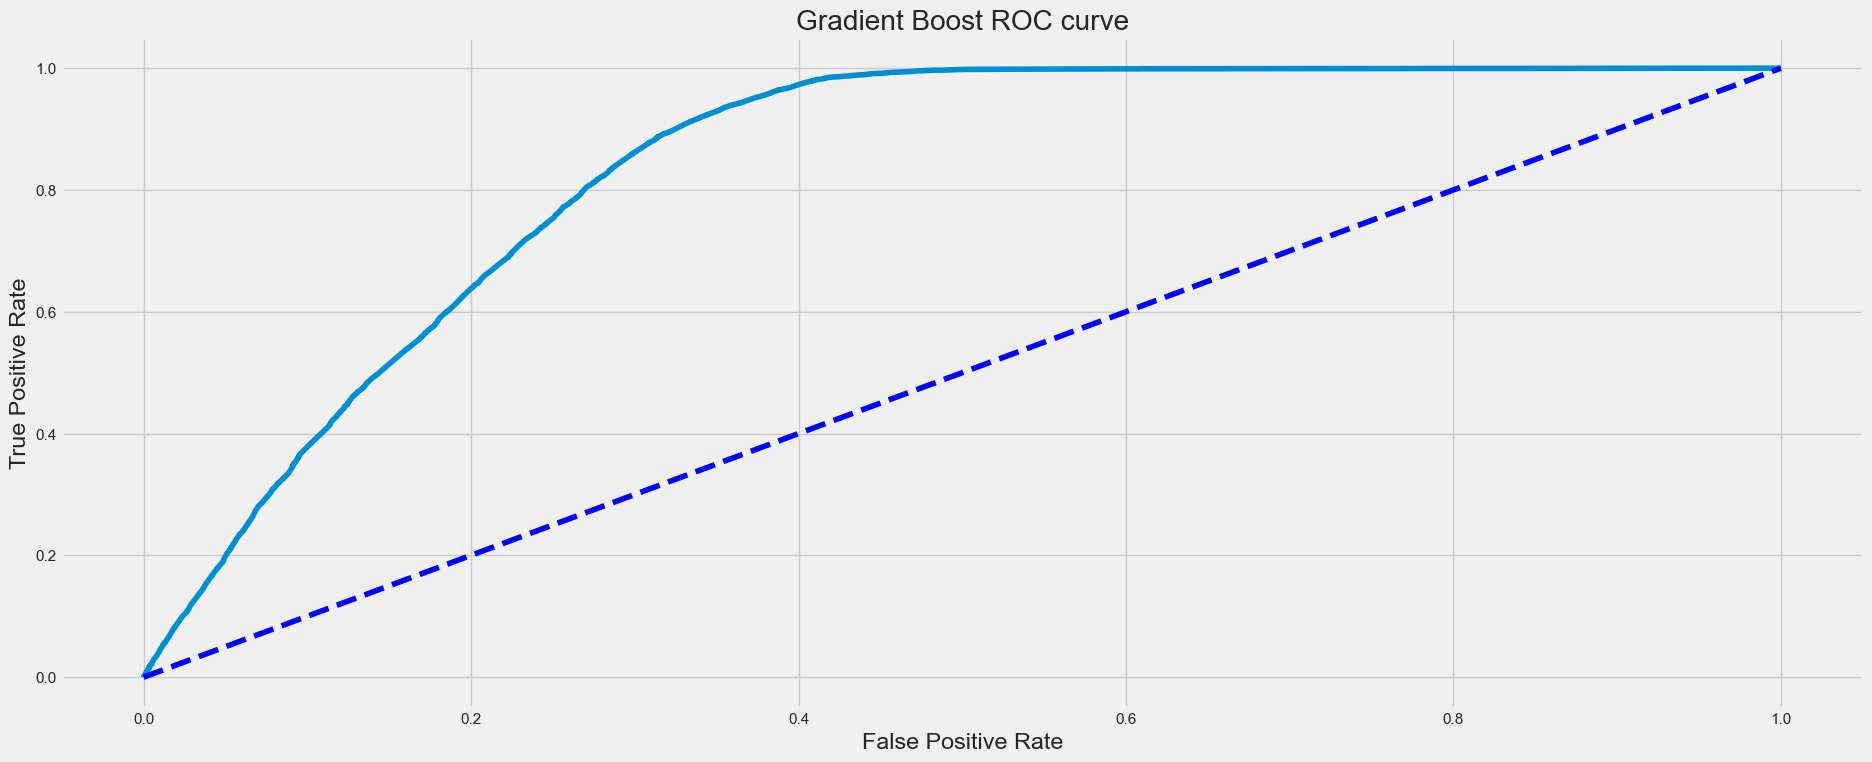

In [69]:
falposr, truposr, _ = roc_curve(y_test, y_pred_grd_prob)
plt.title('Gradient Boost ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[10088  5529]
 [ 1019 14504]]



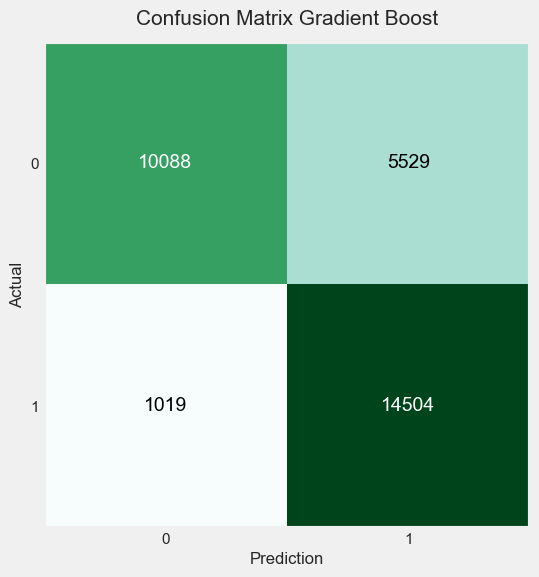

In [70]:
cmgrd = confusion_matrix(y_test, y_pred_grd)
print(cmgrd)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmgrd, figsize=(6, 6), cmap=plt.cm.BuGn)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Gradient Boost', fontsize=15, pad=12)
plt.show()

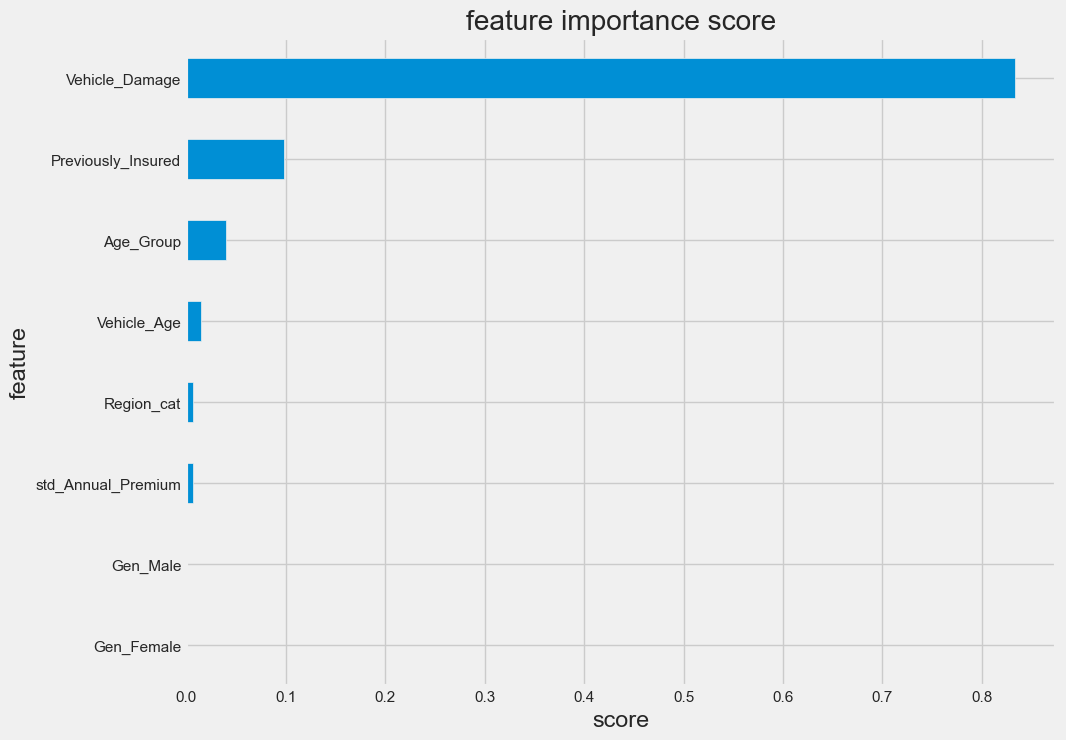

In [71]:
show_feature_importance(grdmodel)

Setelah dilakukan modelling menggunakan `Logistic Regression`, `K-Nearest Neighbor`, `Decision Tree`, `XGBoost`, `Random Forest`, `LightGBM`, `Gradient Boost` didapatkan hasil bahwa model `Logistic Regression` merupakan model terbaik yang digunakan 

## Hyperparameter Tuning

### Menggunakan Random Search

In [117]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.0001, 1, 100)]
hyperparameters = dict(penalty=penalty, C=C)

lg = LogisticRegression()
rs = RandomizedSearchCV(lg, hyperparameters, random_state=42, cv=5)
rs.fit(X_train, y_train)
eval_classification(rs)

Recall: 0.9794015611448396


### Menggunakan Grid Search

In [119]:
penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.0001, 1, 100)]
hyperparameters = dict(penalty=penalty, C=C)

lg = LogisticRegression()
gs = GridSearchCV(lg, hyperparameters, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

# Menampilkan hyperparameter terbaik
print("Hyperparameter terbaik:", gs.best_params_)

# Menampilkan nilai recall terbaik
print("Nilai Recall terbaik:", gs.best_score_)

Hyperparameter terbaik: {'C': 0.010199999999999999, 'penalty': 'l2'}
Nilai Recall terbaik: 0.7848560212008754
